#### Capstone Project Proposal
Arthur: Wilson Lau
Date: July 2016

## Introduction
The problem I want to address in my capstone project is to help real estate investors to discover high potential zipcodes to buy their investment rental properties.

## The Problem
Real estate investment is a passive income opportunity for investors to accumulate return without active management.  Significant long term appreciation is possible for real estate.  However, appreciation often happens in short period of time and the appreciation is heavily affected by local market condition.  It is difficult for out-of-the-market investors to detect local trend and acquire properties before price goes up.  My capstone project is trying to help investors to detect real estate investment opportunities and be able to predict which zipcodes will experience significant appreciation in the near future. 

## Client
My client will be real estate investors who are interested in making investment outside of their local market they live in.  Although real estate generally appreciate steadily, significant gain happens within short period of time.  Real estate price is largely affected by changing conditions in local market.  Significant business development such as local government adding favourable policy or large employer launching new facility could drive up home and rental price, but this kind of news often remains local until late stage of its development, and it is hard for investors outside the region to discover the investment opportunity.  This project is trying to detect the early signal of local real estate appreciation in different zipcodes, so investors have opportunity to acquire properties before significant appreciation happens.  

## Dateset
Two datasets are used in this analysis.  The first dataset is the home price dataset from Quandl's Zillow data.  This dataset is a monthly time series showing the change of home price and other data related to home price such as median rent price, price to rent ratio, etc...  
The second dataset is IRS tax income based on zipcodes.  This IRS data include data like Ajusted Gross Income, Schedule A deduction, etc... 


## Approach

My project is divided into two stages:

# Stage One
- The first stage is to use anomaly detection technique to discover which zipcodes have success sprike of upward price appreciation. 
- The anomaly detection technique used is to compare new monthly home price with historical price as well as the price change of the surrending areas.  A zipcode is considered to have a sprike when it increases significantly over its previous months and also the average of its entire region. 

# Stage Two
- More data such as IRS income data will be collected for the zipcodes that have sudden increase of home price.  
- Those new dataset will be used to figure out what feature contributes to the price appreciation and a predictive model will be created to predict which zipcodes will have price appreciation in the near future. 

## Deliverables
My deliverables will include a python notebook covering the full report with data analysis and prediction model.  I will also create a powerpoint slide deck to highlight the important findings in my report. 

#### Capstone Milestone Report
Arthur: Wilson Lau
Date: July 2016

### Capstone Project Data Story



# What important fields and information does the data set have?
The important columns for the home price dataset is the time(date end of the month), home price and their corresponding zipcode. In addition, to fully evaluate the potential for rental property investment, few columns indiciating rent price and the  relationship between rent and home sales price will probably be important for the analysis as well.  

The IRS dataset provides additional dimensions to the analysis.  Job opportunities and income growth are probably the most factors to drive profitability for rental properties.  The IRS dataset has columns like AGI which indicates the income level for the corresponding zipcodes, and columns like total number of tax return filed which could indicate the job growth in the region. 


# What are its limitations i.e. what are some questions that you cannot answer with this data set?
The home price dataset actually have 22 columns.  For example, it has columns for different home size e.g. 1 bedroom, 2 bedroom, 3 bedroom, price per square foot, average listing price, etc...  Since it seems that most of these columns are highly corelate to home price, they may not be very helpful for predicting home price.

The IRS dataset has columns showing the aggregated number of all tax filers in different zipcodes.  However, those numbers are by years, so there is no monthly breakdown available.  

# What kind of cleaning and wrangling did you need to do?
Quandl's API is very powerful and very flexible.  At the same time, it is a bit complicated to pull the home price.  One way to pull home price is to pass zipcode as input parameter, and Quandl will return the historical price data with all the columns related to that zipcode.  So, to get the data, I will need to use a zipcode dataset that contains all the zipcode of the US and then use the Quandl API to pull data one zipcode at a time.  The home price data is quite clean and there is no much cleaning needed afterwards. 

# Are there other datasets you can find, use and combine with, to answer the questions that matter?
The home price dataset and IRS dataset need to merge to provide variance for good prediction.  Home price changes based on many factors.  Job opportunity is probably one of the most significant factor to drive home and rental price up or down.  IRS dataset data including adjusted gross income and number of total return filed indicates both the level of income growth and job opening growth for a given zipcode.  Merging the home price and IRS datasets provide a more comprehensive pictures of more significant factors affecting rental real estate opportunities.  





## Dataset Collection & Processing

### Collecting Home Price Dataset

The home price dataset is published by Zillow and made available by Quandl.  Quandl provides a number of API to get the dataset.  I find that the best way for my project is to use the API that passes one target zipcode and retrieves its historial time series price data.  To set the data problem at a managable size, I decided to process only the zipcodes in California.  



In [1]:
# get the full list of California zipcode and count how many are there 
import pandas as pd
zipcode = pd.read_csv('./data/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']
print "Number of Zipcodes in California: ", calzipcode.shape[0]

Number of Zipcodes in California:  2792


### Collecting Home Price Dataset

From selecting "Caifornia" from the us_postal_codecs.csv file, I found that there are about 2792 zipcodes in California. Since the Quandl API has restriction on number of calls within a certain time period, I decided to manually call the API a small number of zipcodes at a time and store the returning datasets in separate pickle files.  The followings are the codes I used to call the Quandl API.   


In [2]:
### The following codes being comment out are used to all Quandl APIs

# import Quandl
# import pandas as pd
# import pickle

# startzipcodeIndex = int(2790) # I manually change the starting and ending index number and call the API until I get all 2792 zipcodes
# endzipcodeIndex = int(2792)

# df = pd.DataFrame()
# indicatorCode = {'All Homes': 'A',\
#                 'Single Family Residences': 'SF',\
#                 'Condominiums': 'C',\
#                 'Price per Square Foot':'MVSF',\
#                 '1 Bedroom':'1B','2 Bedroom':'2B','3 Bedroom':'3B','4 Bedroom':'4B','5 or More Bedroom':'5B',\
#                 'Median Rent, Homes Listed for Rent':'RMP',\
#                 'Estimated Rent, All Homes in Region':'RAH',\
#                 'Estimated Rent per Square Foot':'RZSF',\
#                 'Price-to-Rent Ratio':'PRR',\
#                 'Median List Price':'MLP',\
#                 'Median Sale Price':'MSP',\
#                 'Median List Price per Square Foot':'MLPSF',\
#                 'Median Sale Price per Square Foot':'MSPSF',\
#                 'Listings with Price Cut in Last 30 Days':'LPC',\
#                 'Ratio of Sale Price to List Price':'SLPR',\
#                 'Number of Homes for Rent':'HF','Percentage of Sales that were Foreclosures':'FR'};
# dfall = pd.DataFrame(columns=['Date','ZipCode','HomePrice'])

# #loop through zipcodes to get home price data
# for idx,zc in enumerate(calzipcode.iloc[startzipcodeIndex:endzipcodeIndex]['Postal Code']):
#     request = []
#     for code in indicatorCode.values():
#         request.append('ZILL/Z' + str(int(zc)) + '_' + code) #formulate the Quandl request to include the specific column needed
#     data = Quandl.get(request, authtoken='1cydpVS315ZR2iBTpyPi')  #make the request and get result back
#     data.columns = indicatorCode.keys() # add column names
#     data['ZipCode'] = str(int(zc)) # add a column to show zipcode 
#     df = df.append(data) # append results to the main dataframe 

# #write dataframe to file
# dfname = './DataPfiles/' + str(int(calzipcode.iloc[startzipcodeIndex]['Postal Code'])) + "_to_" + str(int(calzipcode.iloc[endzipcodeIndex-1]['Postal Code'])) + ".p"
# pickle.dump( df, open( dfname, "wb" ) )
# print 'Done: ' + dfname

### After pulling all 2792 California zipcodes, I have all the home price data stored in the following pickle files.
import os
import glob
for filename in glob.glob(os.path.join('.\\DataPfiles\\', '9*.p')):
    print filename

.\DataPfiles\90001_to_90174.p
.\DataPfiles\90185_to_90620.p
.\DataPfiles\90621_to_91024.p
.\DataPfiles\91025_to_91346.p
.\DataPfiles\91350_to_91706.p
.\DataPfiles\91708_to_91943.p
.\DataPfiles\91944_to_92119.p
.\DataPfiles\92120_to_92251.p
.\DataPfiles\92252_to_92612.p
.\DataPfiles\92613_to_93062.p
.\DataPfiles\93063_to_93524.p
.\DataPfiles\93526_to_94002.p
.\DataPfiles\94003_to_94307.p
.\DataPfiles\94308_to_94955.p
.\DataPfiles\94956_to_95306.p
.\DataPfiles\95307_to_95569.p
.\DataPfiles\95570_to_95931.p
.\DataPfiles\95932_to_96053.p
.\DataPfiles\96054_to_96064.p
.\DataPfiles\96065_to_96113.p
.\DataPfiles\96114_to_96160.p
.\DataPfiles\96161_to_96162.p


### Procesing Home Price Dataset

Since the Quandl Zillow data is relative clean, there is not much cleaning needed.  The main processing here is to identify the "hot" zipcodes and in which month and year they are "hot".  These "hot" zipcodes will be the main subject of my analysis and I will try to develop a prediction model to predict which zipcodes may become hot before they actually happen.  

The way I zipcode to be hot is to try to find which zipcode and in which months has its price increase sigificantly higher than the mean price with the same zipcode and also than the rest of the zipcode.

#### Labeling "hot" and "code"zipcodes
The way "hot" zipcodes are labeled is through the manual process of detecting sudden home price increase within the same zipcodes as well as across different zipcodes.  The current abnormally detection used is to find the change of the three months moving average of home price to be 1.5 z score over previous month as well as over the average price of all zipcodes.  Then, I label those zipcodes as "hot" in a new column and label them as "cold" otherwise. 


In [3]:
### These codes are trying to identify the "hot" zipcodes. 

#load home price data into dataframe
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import os
import glob
from os import path
import dateUtility
import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 1000)

def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

#load home price data from Datafiles
df = pd.DataFrame()
for filename in glob.glob(os.path.join('.\\DataPfiles\\', '9*.p')):
    df = pd.concat([df, pd.read_pickle(filename)], axis=0)
# there may be a problem here.  There are only about 1700 zipcodes in the .p file although CA has over 2700 zipcode.  

### Pivot indivudal columns into a new dataframe for analysis: 
### 1) Put 1) All Homes prirce 2) Price-To-Rent Ratio into rows and grouped them by zipcode
df = df.reset_index()
dfAllHomes = df.pivot(index='index', columns='ZipCode', values='All Homes')
dfPriceToRent = df.pivot(index='index', columns='ZipCode', values='Price-to-Rent Ratio')  #I didn't make use of this feature now,but may do so later

### calcaluate the home price's moving average for every 3 months, with minimal of 3 months
dfAllHomesMovingAve = pd.rolling_mean(dfAllHomes,window=3,min_periods=3)

### shift entire set of Moving Average number downward for one month
### This is needed to line up the previous month moving average with the current month moving average in the same row
dfAllHomesMovingAve = dfAllHomesMovingAve.shift(periods=1,freq=None,axis=0)

### since I shift the all rows for one month earlier, so I can just subtract the two dataframe and calculate the price change.
dfAllHomesDiffFromMovAve = dfAllHomes - dfAllHomesMovingAve #price change
dfAllHomesDiffFromMovAvePercent = (dfAllHomes - dfAllHomesMovingAve)/dfAllHomes.shift(periods=1,freq=None,axis=0) #price percentage change
NumOfMonthForward = 6 #set the number of month to include for calculating the predicting average percentage increase
dfAllHomesDiffFromMovAvePercentMovAve = pd.rolling_mean(dfAllHomesDiffFromMovAvePercent,window=NumOfMonthForward,min_periods=NumOfMonthForward) # calculate the moving average percentage increase for 6 months
dfAllHomesDiffFromMovAvePercentMovAve2 = dfAllHomesDiffFromMovAvePercentMovAve.shift(periods=-(NumOfMonthForward-1),freq=None,axis=0) # shift dataframe upward for 5 record so the current month shows the moving average percentage increase for the next 6 months(including current month)
dfAllHomesStdDevInZipCode = dfAllHomesDiffFromMovAvePercentMovAve2.copy() #dataframe to hold z score within zipcode

##loop through each zipcode column
for x in dfAllHomesStdDevInZipCode.columns:
    if sum(dfAllHomesStdDevInZipCode[x].isnull()) > 0:  # if any month has null value, drop the entire zipcode
        dfAllHomesStdDevInZipCode.drop(x,axis=1)
    dfAllHomesStdDevInZipCode[x] = (dfAllHomesStdDevInZipCode[x] - dfAllHomesStdDevInZipCode[x].mean()) / dfAllHomesStdDevInZipCode[x].std()  #calculate z score for All Homes price each month

##Calculate z score comparing price across zipcode
dfAllHomesStdDevAcrossZipCode = dfAllHomesDiffFromMovAvePercent.copy() #dataframe to hold z score across different zipcode
dfAllHomesStdDevAcrossZipCodeCol = dfAllHomesStdDevAcrossZipCode.columns
dfAllHomesStdDevAcrossZipCode['MeanHomePrice'] = dfAllHomesStdDevAcrossZipCode.mean(axis=1)
dfAllHomesStdDevAcrossZipCode['StdDevHomePrice'] = dfAllHomesStdDevAcrossZipCode.std(axis=1)
for col in dfAllHomesStdDevAcrossZipCodeCol:
    dfAllHomesStdDevAcrossZipCode[col] = (dfAllHomesStdDevAcrossZipCode[col] - dfAllHomesStdDevAcrossZipCode['MeanHomePrice']) / dfAllHomesStdDevAcrossZipCode['StdDevHomePrice']
    
# dfAllHomesStdDevAcrossZipCode = (dfAllHomesStdDevAcrossZipCode - dfAllHomesStdDevAcrossZipCode['MeanHomePrice']) / dfAllHomesStdDevAcrossZipCode['StdDevHomePrice']

##drop the two added columns so that match the dataframe size of df..InZipCode and df..AcrossZipCode
dfAllHomesStdDevAcrossZipCode = dfAllHomesStdDevAcrossZipCode.drop('MeanHomePrice',axis=1)
dfAllHomesStdDevAcrossZipCode = dfAllHomesStdDevAcrossZipCode.drop('StdDevHomePrice',axis=1)

##Abnormally Detection method 
##Find out which zipcode and its time frame in the dataframe has z score large than 1.5 in both df..InZipCode and df..AcrossZipCode dataframe
targetZscore = 1.5
targetZipcodeBoolean = ((dfAllHomesStdDevInZipCode > targetZscore) & (dfAllHomesStdDevAcrossZipCode > targetZscore))
# targetZipCodes = dfAllHomesMovingAve[targetZipcodeBoolean]#.dropna
selectedZipCodes = pd.DataFrame(dfAllHomesMovingAve[targetZipcodeBoolean].sum(axis = 0) > 0)  #find out which zipcodes are over target zscore
selectedZipCodes[selectedZipCodes[0] == True] #extract only the zipcode that are over zscore

### pivot a new dataframe moving targeted zipcodes into index joining the month-end time (multi-level) index
TargetZipCode = pd.DataFrame(targetZipcodeBoolean.stack())  # stack zipcode from column names into column
TargetZipCode.columns = ['PredictZipCode'] # specify columne name
TargetZipCode = pd.DataFrame(TargetZipCode.reset_index()) # move index into column
dfPredictZipCode = pd.merge(df,TargetZipCode,on=['index','ZipCode']) #merge targeted zipcode column for prediction into main dataframe(which is loaded from 9*.p files)
dfPredictZipCode.rename(columns={'index':'Month'}, inplace=True)
dfPredictZipCode['Month'] = dfPredictZipCode['Month'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
dfPredictZipCode.set_index(['Month','ZipCode'],inplace=True)

### Convert dfPredictZipcode.PredictZipCode from boolean to float, so false = 0, true = 1
dfPredictZipCode.ix[dfPredictZipCode.PredictZipCode == False,'PredictZipCode'] = 0;
dfPredictZipCode.ix[dfPredictZipCode.PredictZipCode == True,'PredictZipCode'] = 1;
dfPredictZipCode.PredictZipCode = dfPredictZipCode.PredictZipCode.astype(float)
# print sum(dfPredictZipCode.PredictZipCode)


### Clean dataframe by removing np.nan, nan(string), ' '(space) and 0 in the cells and fill those cells with back filling value
# finding dataframe cell with 'nan',' ' and 0 and then turn them into np.nan
for x in dfPredictZipCode.columns:
    if x == 'PredictZipCode':
        break
    nalist = dfPredictZipCode[x].isin(['nan',' ',0])
    dfPredictZipCode.ix[nalist,x] = np.nan #turn them in np.nan so that fillna function can fill values to them 

# use fillna funcion to back filling the value from following rows back to rows above
dfPredictZipCode = dfPredictZipCode.reset_index()  
dfPredictZipCode.set_index("Month")
dfPredictZipCode = dfPredictZipCode.fillna(method='bfill') #to fill most of the empty cells
dfPredictZipCode = dfPredictZipCode.fillna(method='ffill') #to fill the last few cells
dfPredictZipCode = dfPredictZipCode.reset_index()
dfPredictZipCode.set_index(['Month','ZipCode'],inplace=True)
dfPredictZipCode = dfPredictZipCode.drop('index',axis=1)

#check to see if there is still nan like value in the dataframe
# print "Predict Zip:"
# print sum(dfPredictZipCode.PredictZipCode)
# print "nan:"
# print sum(dfPredictZipCode.isin(['nan',' ',0]).values)
# print "null value:"
# print sum(dfPredictZipCode.isnull().values)


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=3,center=False).mean()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=6,window=6,center=False).mean()


In [4]:
print sum((dfAllHomesStdDevInZipCode > targetZscore).sum(axis=1))
print sum((dfAllHomesStdDevAcrossZipCode > targetZscore).sum(axis=1))

# dfAllHomesDiffFromMovAvePercent.std()
##Calculate z score comparing price across zipcode
# dfAllHomesStdDevAcrossZipCode = dfAllHomesDiffFromMovAvePercent.copy() #dataframe to hold z score across different zipcode
# dfAllHomesStdDevAcrossZipCode = dfAllHomesStdDevAcrossZipCode.iloc[[5]]
# print dfAllHomesStdDevAcrossZipCode['90005']
# dfAllHomesStdDevAcrossZipCodeCol = dfAllHomesStdDevAcrossZipCode.columns
# dfAllHomesStdDevAcrossZipCode['MeanHomePrice'] = dfAllHomesStdDevAcrossZipCode.mean(axis=1)
# dfAllHomesStdDevAcrossZipCode['StdDevHomePrice'] = dfAllHomesStdDevAcrossZipCode.std(axis=1)
# for col in dfAllHomesStdDevAcrossZipCodeCol:
#     dfAllHomesStdDevAcrossZipCode[col] = (dfAllHomesStdDevAcrossZipCode[col] - dfAllHomesStdDevAcrossZipCode['MeanHomePrice']) / dfAllHomesStdDevAcrossZipCode['StdDevHomePrice']
# print dfAllHomesStdDevAcrossZipCode['90005']
    


12607
14773


### Collecting IRS (Internal Revenue Service) Dataset

The IRS data I used is obtained from the irs web site - https://www.irs.gov/uac/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi.  It is available as zipped csv files separated for each year from 1998 to 2011.  Since different year's csv files are different in columns, I need to create script to parse data for every year.   I didn't have time to refactor all the codes to a utility function that can be reused.  The following is a sample of code I used in one year.  The entire code for collecting IRS data is available in a separate ipython note at IRSdataCollection.ipynb 

In [7]:
# ###########process IRS dataset
# ### prepare 1998 IRS data
# irsdata = pd.read_csv('./DataPfiles/98zp05ca.csv',header=4, na_values=['**','--'])
# irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
#           'TaxableInterestRtn','TaxableInterestAmt', \
#           'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
#           'ScheduleARtn','ScheduleAAmt'
#           ]
# # irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
# #           'TaxableInterestRtn','TaxableInterestAmt','EarnedIncomeCreditRtn','EarnedIncomeCreditAmt', \
# #           'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalScheduleC','ScheduleFTotalRtn','ScheduleFTotalScheduleF',\
# #           'ScheduleARtn','ScheduleAAmt'
# #           ]
# irsdata.columns= irsCol #assign column names to dataframe
# irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
# irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
# irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
# irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
# irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
# irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
# chars_to_remove = ['*', '**', '--',',']
# for col in irsdata.columns: #clean up data by removing non numeric characters
#     irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

# zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
# calzipcode = zipcode[zipcode.State == 'California']
# # print irsdata.columns
# # print calzipcode.columns
# # print irsdata.ZipCode
# irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
# print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
# irsdata1998 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]
# irsdata1998['AverageAGI'] = irsdata1998.AGI.astype(int) #/ irsdata1998['NumberOfReturns'])
# irsdata1998['NumberOfReturns'] = irsdata1998['NumberOfReturns'].astype(int)
# irsdata1998['AverageAGI'] = irsdata1998['AverageAGI'] * 1000 / irsdata1998.NumberOfReturns

# irsdata1998full = pd.DataFrame(columns=irsdata1998.columns.to_series().append(pd.Series("Month")))
# # irsdata1998full = irsdata1998.copy()

# for x in range(0,irsdata1998.shape[0]):
#     listtemp = []
#     irsdata1998t = pd.DataFrame(columns=irsdata1998.columns)
#     irsdata1998t = irsdata1998t.append([irsdata1998.iloc[x]]*12,ignore_index=True)
#     for i in range(12):
#         thisMonth = ("0%i"%(i+1,))[-2:]
#         d = dateUtility.mkDateTime("1998-%s-02"%thisMonth)
# #         print dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d")
#         listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
#     irsdata1998t["Month"] = pd.Series(listtemp)
#     irsdata1998full = irsdata1998full.append(irsdata1998t, ignore_index=True)

# irsdata1998full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe
# irsdata1998small = irsdata1998full[irsdata1998full.index.get_level_values('Month') == '1998-03-31']
# irsdata1998small2 = irsdata1998full[irsdata1998full.index.get_level_values('ZipCode') == '90011']

# # irsdata1998small = irsdata1998full[irsdata1998full.index.get_level_values('Month') == '1998-03-31']
# ### merge IRS data with zipcode price data
# irsdatafull = irsdata1998full
# print "done"
# # dfPredictZipCodesmall = dfPredictZipCode[dfPredictZipCode.index.get_level_values('Month') == '1998-03-31']
# # dfPredictZipCodesmall = pd.concat([dfPredictZipCodesmall.unstack(level=1),irsdata1998small.unstack(level=1)], axis=1)
# # dfPredictZipCodesmall.stack(level=1)

In [8]:
### merge IRS data with zipcode price data

### retrieve irsdatafull from file system
import pandas as pd
import pickle
irsdatafull = pd.DataFrame()
irsdatafull = pd.read_pickle('.\\DataPfiles\irsdatafull.p')

# merge home price dataframe and IRS dataframe by creating two levels columns with features at level one and zipcodes at level two 
# since the rows for dataframe are now month-end, two dataframes can be concat side by side
dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinalnotstack = dfPredictZipCodeFinal.copy()  # for debugging
dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1) # stack zipcodes back as column index along with month-end


### Cleaning final combinated home price + IRS dataframe 

The IRS dataset is very "messy".  The dataset is available as csv files where data for different year is stored with different csv file.  However, the columns are very from year to year.  Some years have more columns while some have fewer.  In adddition, some data cells include special characters such as "*" and "-" for no good reason.  I learned the hard way and discovered various techniques to locate those special chaaracters and remove them.  Also, I used various forward filling to fill empty cells which comes from those speical characters as well as cell for all 12 months within a single year. 

I need to clean up the dataframe again below because I found that there are empty cells created as pivoting the tables with stack and unstack.


In [9]:
### Clean irsdatafull dataframe by removing nan(string), ' '(space) and 0 in the cells and fill those cells with back filling value

# finding dataframe cell with 'nan',' ' and 0 and then turn them into np.nan
for x in dfPredictZipCodeFinal.columns:
    if (dfPredictZipCodeFinal[x].dtypes == 'object'): # check if the column data type is "O" object, 
        dfPredictZipCodeFinal[x] = dfPredictZipCodeFinal[x].astype(str).str.strip() # then strip any space in the cell
    nalist = dfPredictZipCodeFinal[x].isin(['nan',' ',0,'','.','None'])
    dfPredictZipCodeFinal.ix[nalist,x] = np.nan
#     print dfPredictZipCodeFinal[x].dtypes  #debugging

#use fillna funcion to back filling the value from following rows back to rows above
dfPredictZipCodeFinal['PredictZipCode'].fillna(value=False,inplace=True) # Change the NaN values created during the dataframe merge because of stack/unstack
dfPredictZipCodeFinal = dfPredictZipCodeFinal.reset_index() # need to reset index because the current first level index is grouped by zipcode 
dfPredictZipCodeFinal = dfPredictZipCodeFinal.set_index('level_0') #reset index to month; rows for the same zipcode from different month are listed consecutively
dfPredictZipCodeFinal = dfPredictZipCodeFinal.fillna(method='bfill') #apply back filling with fillna
dfPredictZipCodeFinal = dfPredictZipCodeFinal.fillna(method='ffill') #apply forward filling to correct cells the last cells that didn't get fill with back filling
dfPredictZipCodeFinal = dfPredictZipCodeFinal.reset_index()
dfPredictZipCodeFinal.rename(columns={'level_0':'Month'}, inplace=True)
#### I am disabling the following line for now as making Month and ZipCode doesn't seem to add much value 
# dfPredictZipCodeFinal.set_index(['Month','ZipCode'],inplace=True) #putting back index of Monthly and ZipCode for merging with dfPredictZipCodeFinal later

# debugging: check to see if there is still nan like value in the dataframe
print "nan:"
print sum(dfPredictZipCodeFinal.isin(['nan',' ','',0,'.']).values)
print "null value:"


print sum(dfPredictZipCodeFinal.isnull().values)

nan:
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0 412370      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
null value:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


### Storing clean datasets to pickle file for analysis later

Dataframe will be stored to dfPredictZipCodeFinal.p as follows.

In [12]:
### store clean dataframe to file

import numpy as np
import pandas as pd
import pickle
from scipy import stats
import os
import glob
from os import path
import dateUtility
import datetime as dt

# dfname = './DataPfiles/dfPredictZipCodeFinalold.p'
dfname = './DataPfiles/dfPredictZipCodeFinal.p'
pickle.dump( dfPredictZipCodeFinal , open( dfname, "wb" ) )
print 'Done: ' + dfname

Done: ./DataPfiles/dfPredictZipCodeFinal.p


### Retrieve clean and prepared dataset for analysis

This will make it easier for myself that I don't need to rerun the entire data collecting and cleaning tasks, so I can get the clean dataset for analysis right away. 

In [1]:
### retrieve dfPredictZipCodeFinal from file system
import pandas as pd

dfPredictZipCodeFinal = pd.DataFrame()
dfPredictZipCodeFinal = pd.read_pickle('.\\DataPfiles\dfPredictZipCodeFinal.p')
# dfPredictZipCodeFinal = pd.read_pickle('.\\DataPfiles\dfPredictZipCodeFinalold.p')
print dfPredictZipCodeFinal.shape

(415465, 41)


## Data Exploration and Analysis

The following is my exploratory analysis on the final processed zipcode + irs data dataset.   The main key for the analysis is to understand the important factors that determine whether a zipcode turns hot or cold in any given month.  Many of my analysis here try to group zipcode among hot vs cold and see how the statistics for the different groups. 


### Data Pre-Processing for plotting ###

I re-formatted the dataframe as follows to make it easier for plotting system to generate diagrams for my analysis.  The main thing I change is to change the column indicating whether a zipcode is "hot" or "cold" from 1/0 into string hot/cold.  That makes it easier for plotting system to display the name of the group.  



In [2]:
### simpe grouping analysis ###

#import plotting library
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

dfPredictZipCodeFinalGraph = dfPredictZipCodeFinal.copy()  #copy into a new dataframe for diagram plotting
dfPredictZipCodeFinalGraph.set_index(['Month', 'ZipCode'],inplace=True) #month and zipcode won't be used for group; so make them index
dfPredictZipCodeFinalGraph.rename(columns = {'PredictZipCode':'ZipCode Group'},inplace=True) #change name for diagram display
dfPredictZipCodeFinalGraph['ZipCode Group'].ix[dfPredictZipCodeFinalGraph['ZipCode Group'] == 1.0,:] = 'Hot' #change name for diagram display
dfPredictZipCodeFinalGraph['ZipCode Group'].ix[dfPredictZipCodeFinalGraph['ZipCode Group'] == 0.0,:] = 'Cold'#change name for diagram display 
dfPredictZipCodeFinalGraph.head()
# dfPredictZipCodeFinal.head()


C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1 Bedroom  2 Bedroom  3 Bedroom  4 Bedroom  \
Month      ZipCode                                               
1996-04-30 90001      95100.0   108300.0   122700.0   130400.0   
           90002      79100.0    93700.0   113200.0   116800.0   
           90003      78600.0    91200.0   117900.0   118600.0   
           90004     112200.0   163600.0   223800.0   343700.0   
           90005     111000.0   136900.0   199700.0   322400.0   

                    5 or More Bedroom     AGI  All Homes    AverageAGI  \
Month      ZipCode                                                       
1996-04-30 90001             136900.0  284300   115200.0  19186.124983   
           90002             136900.0  284300   106800.0  19186.124983   
           90003             128000.0  284300   104700.0  19186.124983   
           90004             718200.0  284300   223900.0  19186.124983   
           90005             412400.0  284300   182300.0  19186.124983   

                    Condominiums DepedentExemptionsAmt     ...       \
Month      ZipCode                                         ...        
1996-04-30 90001        160100.0                 18773     ...        
           90002        160100.0                 18773     ...        
           90003        160100.0                 18773     ...        
           90004        160100.0                 18773     ...        
           90005        140700.0                 18773     ...        

                    ScheduleARtn  ScheduleCTotalAmt ScheduleCTotalRtn  \
Month      ZipCode                                                      
1996-04-30 90001            2269              20010              1468   
           90002            2269              20010              1468   
           90003            2269              20010              1468   
           90004            2269              20010              1468   
           90005            2269              20010              1468   

                    ScheduleFTotalAmt  ScheduleFTotalRtn  \
Month      ZipCode                                         
1996-04-30 90001                  198                 18   
           90002                  198                 18   
           90003                  198                 18   
           90004                  198                 18   
           90005                  198                 18   

                    Single Family Residences  TaxableInterestAmt  \
Month      ZipCode                                                 
1996-04-30 90001                    115200.0                3260   
           90002                    106800.0                3260   
           90003                    104700.0                3260   
           90004                    250700.0                3260   
           90005                    332400.0                3260   

                    TaxableInterestRtn  TotalTaxAmt  TotalTaxRtn  
Month      ZipCode                                                
1996-04-30 90001                  3045        19539         8133  
           90002                  3045        19539         8133  
           90003                  3045        19539         8133  
           90004                  3045        19539         8133  
           90005                  3045        19539         8133  

[5 rows x 39 columns]

## "Hot" zipcodes with the most number of months

Zipcodes can be hot or cold in different times.  It is good to know how many times a zipcode is considered as "hot" in any given month throughout the entire time period of the dataset. The following bar chart shows the top 10 zipcodes with the most number of times marked as "hot" in a month. 

Results:  
It looks the top hot zip codes spread through north and south California and between major metropolitan areas as well as more rural areas 
The "hottest" zip codes are 94609 (Oakland, CA) and 93280 (Wasco, CA) with count of "hot" months of 16.  Next is 95113 (San Jose, CA) with 15 and 96093 (Weaverville, CA) with 14.  


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


         PredictZipCodeCount
ZipCode                     
94609                     16
93280                     16
95113                     15
96093                     14
93501                     13
95811                     13
94301                     13
93426                     13
94022                     13
95070                     13


C:\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


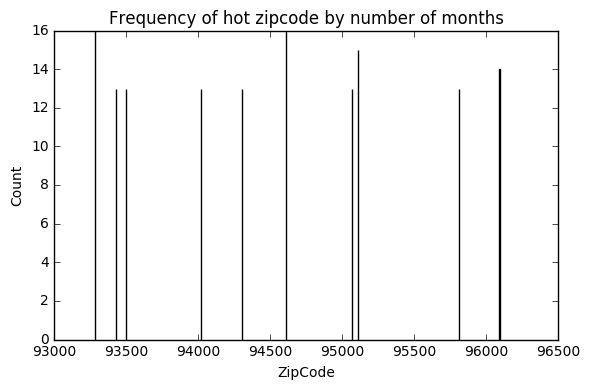

In [3]:
### simpe groupig analysis ###

#for the zipcode ever consided to be targertted, find out for how many years they are selected as target
TargetedZipCodeCount = pd.DataFrame(dfPredictZipCodeFinal[dfPredictZipCodeFinal['PredictZipCode'] == True].groupby(['ZipCode'])['PredictZipCode'].count())
TargetedZipCodeCount.rename(columns = {'PredictZipCode':'PredictZipCodeCount'}, inplace = True)
TargetedZipCodeCount10 = TargetedZipCodeCount.sort('PredictZipCodeCount', ascending=False)[:10] #top 10 zipcodes
print TargetedZipCodeCount10

#plot a bar chart
barchart = plt.bar(TargetedZipCodeCount10.index.astype(str), TargetedZipCodeCount10['PredictZipCodeCount'].astype(int) ) #plot bar chart

plt.xlabel('ZipCode')
plt.ylabel('Count')
plt.title('Frequency of hot zipcode by number of months')
plt.legend()

plt.tight_layout()
plt.show()


## Counting The Number of Hot/Cold Zipcodes by Year

The appearance of "hot" zipcodes may depend on the general economony, so it may be interesting to know the number of "hot" zipcodes in a given year.  In the following bar chart, I count the number of identified "hot" zipcode by year.  

Results:  
- The most number of "hot" zipcode happens in 2004 with 556.  Year 2000 has the second highest with 544.  Year 1999 has the third with 458.   One clear observation is that there are very little or none "hot" zipcodes from 2006 to 2012, which happens to be the period that real estate collapsed and that economic downturn is known as “the great depression".     



               ZipCodeCount     
PredictZipCode          0.0  1.0
Year                            
1996                  11051    9
1997                  14878   31
1998                  29022   63
1999                  14911  458
2000                  14805  544
2001                  29043  105
2002                  28960  188
2003                  15073  295
2004                  28208  556
2005                  28413  387
2006                  28679   13
2007                  28763    4
2008                  23565    3
2009                  18602   10
2010                  18706    1
2011                  18834    1
2012                  17390   71
2013                  16504  286
2014                  16828   56
2015                  10135   14


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


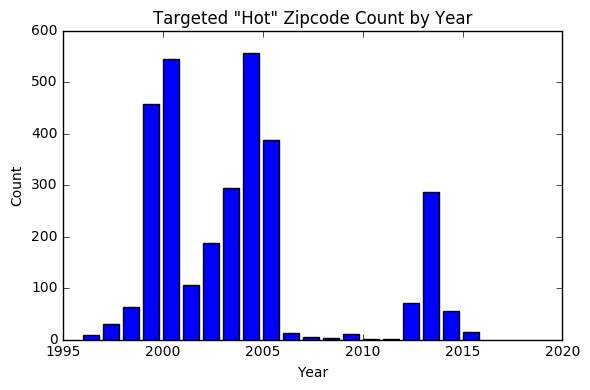

In [5]:
### simpe groupig analysis ###

## the number of targeted zipcode in different year.  
dfPredictZipCodeFinal['Year'] = dfPredictZipCodeFinal.Month.str[:4]  # add a new column to store which year(first 4 digits of date) based on Month 
TargetZipCodeCount = pd.DataFrame(dfPredictZipCodeFinal.groupby(['Year','PredictZipCode']).count()['ZipCode'])
TargetZipCodeCount = TargetZipCodeCount.unstack(1)
TargetZipCodeCount = TargetZipCodeCount.rename(columns = {'ZipCode':'ZipCodeCount'})
TargetZipCodeCount.fillna(0,inplace=True)
print TargetZipCodeCount

TargetedZipCodeCount = pd.DataFrame(dfPredictZipCodeFinal[dfPredictZipCodeFinal['PredictZipCode'] == True].groupby(['ZipCode'])['PredictZipCode'].count())
TargetedZipCodeCount.rename(columns = {'PredictZipCode':'PredictZipCodeCount'}, inplace = True)
TargetedZipCodeCount.sort('PredictZipCodeCount', ascending=False)

# plot the bar chart for hot zipcode count by year
zipcodeCountBarChart = plt.bar(TargetZipCodeCount['ZipCodeCount'][0.0].reset_index()['Year'].astype(int), \
                           TargetZipCodeCount['ZipCodeCount'][1.0].reset_index()[1.0])


plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Targeted "Hot" Zipcode Count by Year')
plt.legend()

plt.tight_layout()
plt.show()

## Compare home price grouped by targeted zip code

This analysis tries to understand the differences in median home prices between hot zipcodes and cold zip codes across different size of home.  I pull specifically the home price columns for 1, 2, 3, 4 and 5 or more bedroom as well Overall and calculate their average price grouped by zipcode group.  It seems logically that "hot" zipcodes have higher price because homes in "hot" zip codes may be more desirable.  I created 6 boxplots to examine the median of home price for different home size.  

Results:    
- From the observation of all the boxplots, there is only one column group (the one bedroom) whose hot zipcodes median price is higher than its cold zipcodes'.  The rest of the boxplots including the overall home price boxplot have their hot zip code median home price less than cold zip code.  
- More importantly, the differences between hot and cold zip codes median price get larger as the number of bedroom increases.  The 5 bedroom properties’ cold zip code median price is significantly higher than its hot zip code median price.  One of the possible explanation for that is that the larger (more bedrooms) the property is, the bigger the room is for price to increase, especially for properties with relatively low median price. 
- It is not totally clear why one bedroom property in hot zipcodes has higher media price than code zipcodes.  It is possible that single and small families are easier to move and are attracted to locations with job growth, so they drive up the rental price and median home price as they move to hot zipcode areas. 

C:\Anaconda2\lib\site-packages\pandas\tools\plotting.py:3352: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  "when creating axes", UserWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C97F9B0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000142F8DD8>], dtype=object)

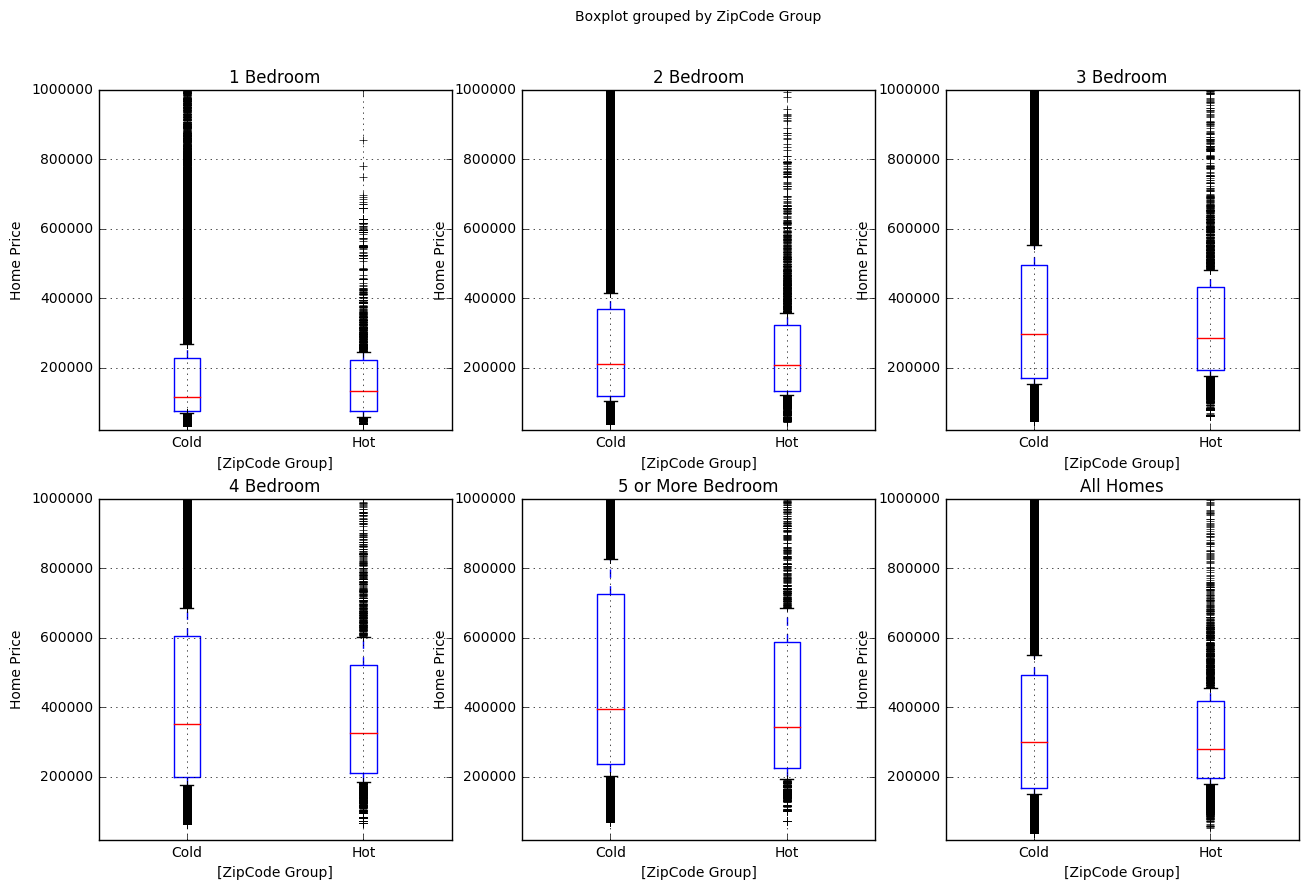

In [6]:
## compare home price grouped by targeted zip code

#pull only the columns related to selling price plus the label column PredictZipCode
dfPredictZipCodeFinalGraphHomePrice = dfPredictZipCodeFinalGraph[['1 Bedroom','2 Bedroom','3 Bedroom', \
                                                                  '4 Bedroom','5 or More Bedroom','All Homes', \
                                                                  'ZipCode Group']]
fig, axes = plt.subplots(2,3,figsize=(15,10)) #create fig with subplot of one row and six columns
fig.suptitle('Home Price Analysis')
# fig.set_ylim(20000,2000000)
# fig.set_ylim()

for ax in fig.axes: #loop through the axes
    ax.set_ylim(20000,1000000) #set y axis range
    ax.set_xlabel('ZipCode Group')
    ax.set_ylabel('Home Price')
    
dfPredictZipCodeFinalGraphHomePrice.boxplot(by='ZipCode Group',ax=axes, whis=[20, 80]) #plot boxplot grouped by zipcode group




## Comparing "Estimated Rent per Square Foot" between hot and cold zipcodes

Rent is an important factor to determine whether rental property is profitable or not.  It will be good to understand the relationship between rent per square foot and hot/cold zipcodes.  I have the following hypthosis testing to run:

Hypothesis testing   
- Null hypothesis:  "hot" zipcodes have higher rent per square foot than "cold" zipcodes.   
- Alternative hypothesis:  "hot" zipcodes do not have rent per square foot than "cold". 

I calculated the mean rent per square foot for both the hot and cold zipcode groups.  

Results    
- The boxplot shows that the "Hot" zipcodes has higher rent per square foot than "cold" zipcodesBased on these results; therefore, I am rejecting the alternative hypothsis and confirm that the null hypothesis of "hot" zipcodes having higher rent per square foot is true. 

Results:
- The boxplot shows that the "Hot" zipcodes has higher rent per square foot than "cold" zipcodesBased on these results.  The estimated rent per square foot for hot and cold zip codes are 1.31 and 1.27 respectively. 

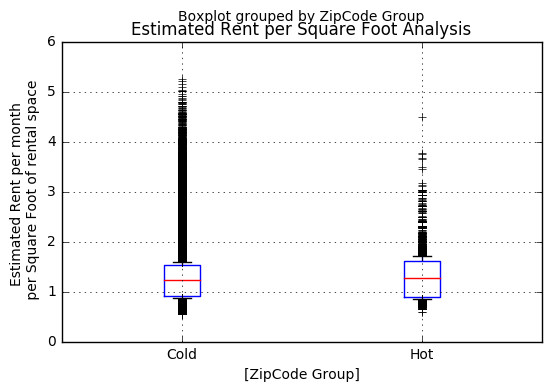

,Estimated Rent per Square Foot
ZipCode Group,
Cold,1.267083
Hot,1.312438


In [7]:
### Comparing "Estimated Rent per Square Foot" between hot and cold zipcodes
    
ax = dfPredictZipCodeFinalGraph[['Estimated Rent per Square Foot','ZipCode Group']].boxplot(by='ZipCode Group', whis=[20, 80]) #plot boxplot grouped by zipcode group
ax.set_title('Estimated Rent per Square Foot Analysis')
ax.set_ylabel('Estimated Rent per month \n per Square Foot of rental space')
plt.show()

dfPredictZipCodeFinalGraph[['Estimated Rent per Square Foot','ZipCode Group']].groupby('ZipCode Group').mean()




## Comparing Price-to-Rent Ratio between hot and cold zipcodes

It is also interesting to see the relationship between price, rent and hot/cold zipcode group. Price-to-rent ratio is the median home sales price over median annual rent. Price-to-rent ratio indicates the cost for investors to acquire investment properties. High price-to-rent ratio means that investors will need to invest more to generate the same monthly rental income return. Low price-to-rent ratio means that investors will need to put up less initial investment, so their return-on-income will generally higher. 

Results:
- As I calculate the average price-to-rent ratio between hot and cold zipcode group, I found that "hot" zipcodes have slightly higher average price-to-rent and its range between 25% and 75% percentile is also wider than "cold" zipcodes. 


,Price-to-Rent Ratio
ZipCode Group,
Cold,15.183392
Hot,16.311877


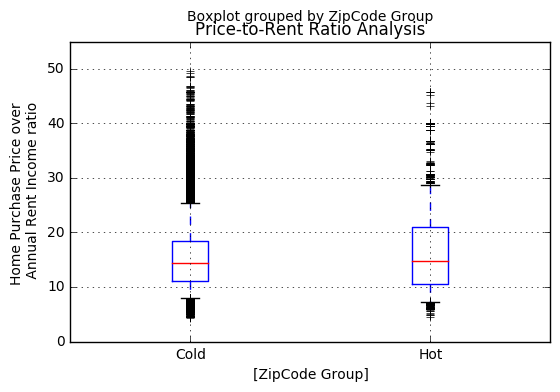

In [8]:
### Comparing Price-to-Rent Ratio between hot and cold zipcodes

ax = dfPredictZipCodeFinalGraph[['Price-to-Rent Ratio','ZipCode Group']].boxplot(by='ZipCode Group', whis=[5, 95]) #plot boxplot grouped by zipcode group
ax.set_title('Price-to-Rent Ratio Analysis')
ax.set_ylabel('Home Purchase Price over \n Annual Rent Income ratio')
ax.set_ylim(0, 55)

dfPredictZipCodeFinalGraph[['Price-to-Rent Ratio','ZipCode Group']].groupby('ZipCode Group').mean()


## Comparing AGI between hot and cold zipcodes

Income level is probably another important factor driving zipcodes from "cold" to "hot". AGI is Adjusted Gross Income - generally the total income amount of tax payers before tax deduction. When the median AGI in a region increases, that generally means that the economic activities in the region is growing, and people generally can afford more to pay the essentials like rent or other disposable items. I analyzed the relationship between average AGI between "hot" and "cold" zipcode groups. I generate a table showing the mean, standard deviation, quantiles, etc between hot and cold zipcode groups. Also, I made a boxplot to visually see the differences. 

Results:   
- The analysis shows that the mean of the average AGI for hot zip codes is much smaller than cold zip codes.  The mean of the average AGI for hot zip is about 38260 while the average AGI for cold zip code is 54952.  Also, the standard deviation for average AGI for hot zip codes is smaller than that for cold zip codes.
- This result seems to be a bit surprising.  One explanation for this result is because lower income zip codes provide relatively low baseline for home price to appreciate and proportional wise their appreciation goes up in higher percentage. 

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AverageAGI                                            \
                   count          mean           std           min   
ZipCode Group                                                        
Cold            412370.0  54952.941933  47393.356709    717.814371   
Hot               3095.0  38260.191767  23052.435136  17537.713711   

                                                                       
                        25%           50%           75%           max  
ZipCode Group                                                          
Cold           28902.462424  45371.936569  77217.094371  1.227792e+06  
Hot            20294.132397  27990.158123  46959.687906  2.093768e+05

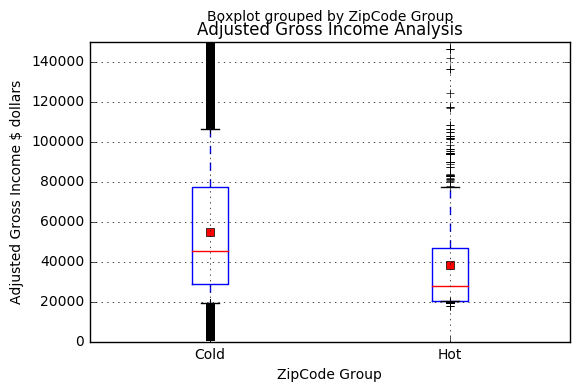

In [9]:
## Comparing AGI between hot and cold zipcodes

# fig, axes = plt.subplots(1,1,figsize=(15,10)) #create fig with subplot of one row and six columns
# for ax in fig.axes: #loop through the axes
#     ax.set_ylim(1000,250000) #set y axis range
#     ax.set_xlabel('ZipCode Group')
#     ax.set_title('Adjusted Gross Income Analysis')
#     ax.set_ylabel('Adjusted Gross Income $ dollars')
    

dfAGI = dfPredictZipCodeFinalGraph[['AverageAGI','ZipCode Group']]
# dfAGI['AGI'] = dfAGI['AGI'].astype('float') #convert AGI column from object to float because groupby would have thrown error
dfAGI['AverageAGI'] = dfAGI['AverageAGI'].convert_objects(convert_numeric=True) #convert AGI column from object to float because groupby would have thrown error
# dfAGI.boxplot(by='ZipCode Group', ax=axes, whis=[5, 95], showmeans=True) #plot boxplot grouped by zipcode group
ax = dfAGI.boxplot(by='ZipCode Group', whis=[5, 95], showmeans=True) #plot boxplot grouped by zipcode group
ax.set_ylim(0,150000) #set y axis range
ax.set_xlabel('ZipCode Group')
ax.set_title('Adjusted Gross Income Analysis')
ax.set_ylabel('Adjusted Gross Income $ dollars')

dfAGI.dropna().groupby('ZipCode Group').describe().unstack()


# fig, axes = plt.subplots(1,1,figsize=(15,10)) #create fig with subplot of one row and six columns
# for ax in fig.axes: #loop through the axes
#     ax.set_ylim(40000,430000) #set y axis range
#     ax.set_xlabel('ZipCode Group')

# dfAGI = dfPredictZipCodeFinalGraph[['AGI','ZipCode Group']]
# # dfAGI['AGI'] = dfAGI['AGI'].astype('float') #convert AGI column from object to float because groupby would have thrown error
# dfAGI['AGI'] = dfAGI['AGI'].convert_objects(convert_numeric=True) #convert AGI column from object to float because groupby would have thrown error
# dfAGI.boxplot(by='ZipCode Group', ax=axes, whis=[5, 95], showmeans=True, meanline=True) #plot boxplot grouped by zipcode group
# dfAGI.dropna().groupby('ZipCode Group').describe().unstack()

## Comparing year by year changes for hot and cold zipcode groups on different columns

Knowing how the different aspects of hot/cold zipcode changes year over year can help to identify additional features that have significant impacts to the changes of zipocde from hot to cold or vice versa.  The following analysis focuses on plotting the year over year changes for different features including Average home price, AGI, Estimated Rent per Square Foot,Price-to-Rent Ratio, Listings with Price Cut in Last 30 Days, Number of Single Family Residences, Salary Wage amount and Salaries Wages Tax Return. 

Result:  
- There is no clear pattern that can be identified except hot zipcode numbers tend to go up in 2015. But, that may due to some data collection.  




C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


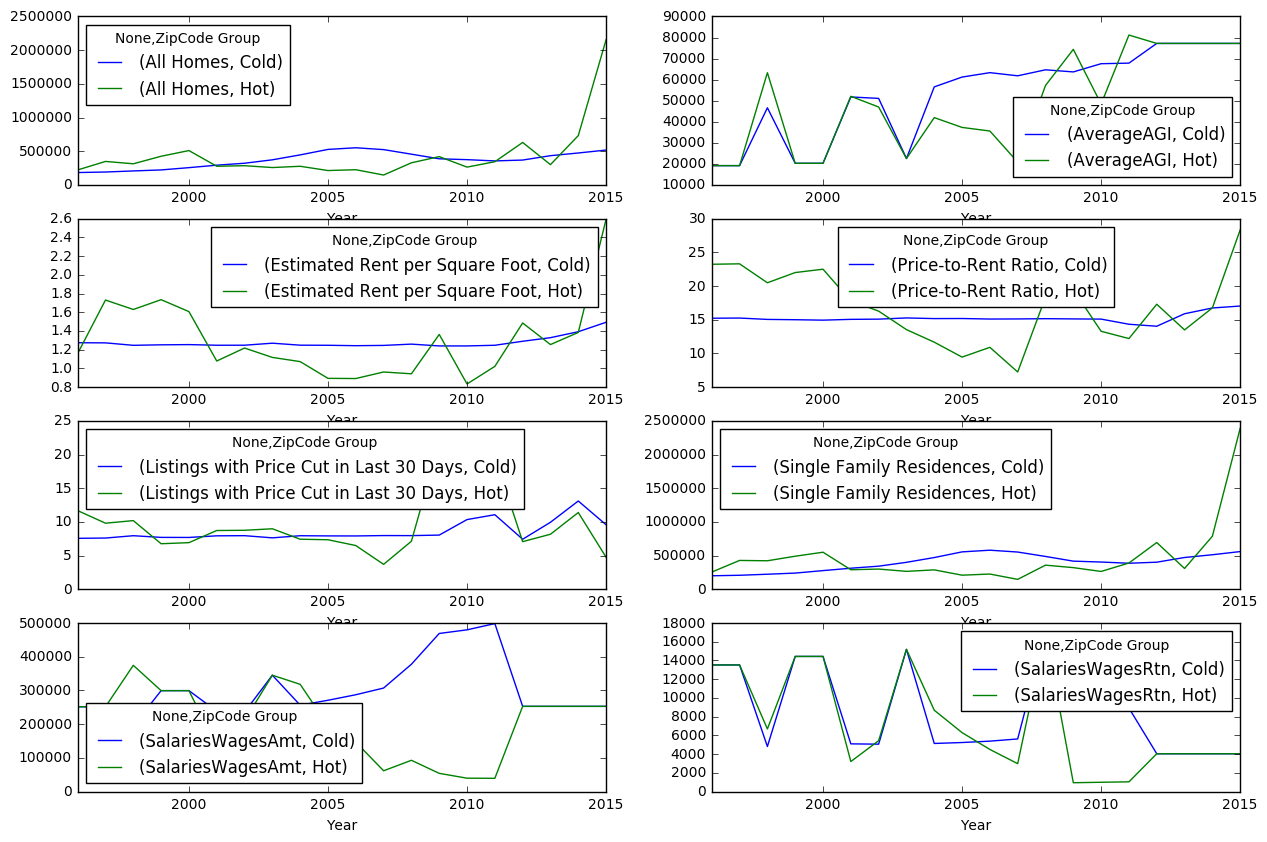

In [10]:
### Comparing hot and cold zipcodes' average All Homes price year by year 

# fig, axes = plt.subplots(1,2) #create fig with subplot of one row and six columns
# for ax in fig.axes: #loop through the axes
#     ax.set_ylim(40000,430000) #set y axis range
#     ax.set_xlabel('ZipCode Group')

# dfAGI = dfPredictZipCodeFinalGraph[['AGI','ZipCode Group']]
# dfAGI['AGI'] = dtest1['AGI'].astype('float') #convert AGI column from object to float because groupby would have thrown error
# dfAGI.boxplot(by='ZipCode Group', ax=axes, whis=[5, 95], showmeans=True, meanline=True) #plot boxplot grouped by zipcode group
# dfAGI.groupby('ZipCode Group').describe().unstack()

# reformat the dataframe for plotting purpose
dfPredictZipCodeFinalGraphTime = dfPredictZipCodeFinalGraph.reset_index()
dfPredictZipCodeFinalGraphTime['Month'] = pd.to_datetime(dfPredictZipCodeFinalGraphTime['Month'])
dfPredictZipCodeFinalGraphTime.set_index('Month',inplace=True)
dfPredictZipCodeFinalGraphTime['AGI'] = dfPredictZipCodeFinalGraphTime['AGI'].astype(float)
dfPredictZipCodeFinalGraphTime['SalariesWagesAmt'] = dfPredictZipCodeFinalGraphTime['SalariesWagesAmt'].astype(float)
dfPredictZipCodeFinalGraphTime['SalariesWagesRtn'] = dfPredictZipCodeFinalGraphTime['SalariesWagesRtn'].astype(float)

# colForAnalysis = ['All Homes','AGI','Estimated Rent per Square Foot','Price-to-Rent Ratio', \
#                   'Listings with Price Cut in Last 30 Days','Single Family Residences', \
#                   'SalariesWagesAmt', 'SalariesWagesRtn'] #list the interesting columns to add to the plot below
colForAnalysis = ['All Homes','AverageAGI','Estimated Rent per Square Foot','Price-to-Rent Ratio', \
                  'Listings with Price Cut in Last 30 Days','Single Family Residences', \
                  'SalariesWagesAmt', 'SalariesWagesRtn'] #list the interesting columns to add to the plot below
colForAnalysis.extend(['ZipCode Group']) #add the extra ZipCode Group column for grouping hot and cold zipcodes
dfPredictZipCodeFinalGraphTimeCol = dfPredictZipCodeFinalGraphTime[colForAnalysis] #extract just the interesting zipcodes
dfPredictZipCodeFinalGraphTimeCol['Year'] = dfPredictZipCodeFinalGraphTimeCol.index.year #add the year column

fig, axes = plt.subplots(4,2,figsize=(15,10)) #create fig with subplot of one row and six columns
colindex = 0
for ax in fig.axes: #loop through the axes
    dfPredictZipCodeFinalGraphTimeCola = pd.pivot_table(dfPredictZipCodeFinalGraphTimeCol,index=['Year'], columns=['ZipCode Group'], values=[colForAnalysis[colindex]])
    colindex += 1
    dfPredictZipCodeFinalGraphTimeCola.plot(ax=ax)


## Plot the hot zipcodes on a map

Knowing where the hot zipcodes are geographically will also be very helpful for investors. The following analysis plot the top hot zipcodes with the highest number of month being marked as hot.  The top 30 zip codes with highest frequency of being hot is plotted on the following map:

Results:
- The hot zip codes seem to spread pretty evenly all over the entire California. There seems to have more hot zip codes in the San Francisco Bay Area in North California and around Bakersfield near South California.   The main Los Angeles area has only one hot zip code, and there is none in the San Diego area.  


In [11]:
### simpe groupig analysis ###

## plot the hot zipcodes on a map
import folium

#load zipcode list from file
zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

#create map object and set the initial center position to Bakersfield
map_cal = folium.Map(location=[35.3733, -119.0187],
                   zoom_start=6,
                   tiles= "Stamen Terrain")

#find hot zipcodes sorted by the number of period considered as hot
TargetedZipCodeCount = pd.DataFrame(dfPredictZipCodeFinal[dfPredictZipCodeFinal['PredictZipCode'] == True].groupby(['ZipCode'])['PredictZipCode'].count())
TargetedZipCodeCount.rename(columns = {'PredictZipCode':'PredictZipCodeCount'}, inplace = True)
TargetedZipCodeCount.sort('PredictZipCodeCount', ascending=False)

numOfZipCodeToMap = 30 #set the number of zipcode to be mapped
#find the top zipcodes to map  
hotzipindex = calzipcode['Postal Code'].isin(TargetedZipCodeCount.sort('PredictZipCodeCount',ascending=False).ix[:numOfZipCodeToMap,].index.astype(float))
dfHotzip = calzipcode.ix[hotzipindex,['Postal Code','Latitude','Longitude']] #extract the matching zipcodes and its lot & long

# mark selected zipcodes on the map
for index, row in dfHotzip.iterrows():
    folium.Marker([row['Latitude'].astype(str), row['Longitude'].astype(str)], popup=row['Postal Code'].astype(int).astype(str)).add_to(map_cal)
    
# print the map
map_cal

# folium.Marker([45.3288, -121.6625], popup='Mt. Hood Meadows').add_to(map_1)
# folium.Marker([45.3311, -121.7113], popup='Timberline Lodge').add_to(map_1)
# map_cal

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## Generate Balanced Dataset

The original datasets are not balanced because there are very few “hot” zip codes identified in the dataset comparing to the “cold” zip codes.  There are a total of 3095 hot zip code month comparing to 412370 cold zip code month.  To produce a balanced training and testing dataset, I need to take samples of the hot and cold zip code month and combine them.  I take 10000 samples with replacement from each of the hot and cold zip code and combine them to generate a 20000 row dataset for modeling training and testing. 

In [12]:
dfPredictZipCodeFinalHot = dfPredictZipCodeFinal[dfPredictZipCodeFinal.PredictZipCode == 1]
dfPredictZipCodeFinalCold = dfPredictZipCodeFinal[dfPredictZipCodeFinal.PredictZipCode == 0]
print "Number of row of hot zipcode: ", dfPredictZipCodeFinalHot.shape[0]
print "Number of row of hot zipcode: ", dfPredictZipCodeFinalCold.shape[0]

# sampling with replacement to generate a dataset of 20000 rows with 10000 hot and 10000 cold zip codes
dfPredictZipCodeFinalHot = dfPredictZipCodeFinalHot.sample(10000,replace=True,random_state=42)
dfPredictZipCodeFinalCold = dfPredictZipCodeFinalCold.sample(10000,replace=True,random_state=42)
# print dfPredictZipCodeFinalHot.shape
# print dfPredictZipCodeFinalCold.shape
dfPredictZipCodeFinalBalanced = dfPredictZipCodeFinalHot.append(dfPredictZipCodeFinalCold)
print "size of balanced dataset ready for training and testing: ", dfPredictZipCodeFinalBalanced.shape[0]
# print "The columns of feature are as follows: "
# dfPredictZipCodeFinalBalanced.info()


Number of row of hot zipcode:  3095
Number of row of hot zipcode:  412370
size of balanced dataset ready for training and testing:  20000


## Spliting training and testing dataset

The processed dataset is divided into training set and testing set to get read for model training.  I decided to split the dataset into 80% training set and 20% testing set.  



In [13]:
###  Prepare training and testing dataset
from sklearn.cross_validation import train_test_split

# separate dataset into training and testing set
X = dfPredictZipCodeFinalBalanced
X.set_index(['Month'],inplace=True) #putting back index of Monthly
# y = X['PredictZipCode'].values * 1  #set dependent variable PredictZipCode from dataframe
y = X['PredictZipCode']  #set dependent variable PredictZipCode from dataframe
X.drop('PredictZipCode',1,inplace=True) #remove PredictZipCode from dataframe

######################################## NEED TO DELETE HERE TO MAKE ENTIRE DATASET FOR MODELING LATER AFTER FULL TESTING
# X = X.ix[75000:80000,:]
# y = y[75000:80000]
######################################## NEED TO DELETE HERE TO MAKE ENTIRE DATASET FOR MODELING LATER AFTER FULL TESTING

# X_train, X_test, y_train, y_test = train_test_split(X.ix[20000:40000,:], y[20000:40000], test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print "training dataset size: ", X_train.shape
print "training predictionlabel size: ", y_train.shape
print "testing dataset size: ", X_test.shape
print "testing predictionlabel size: ", y_test.shape

# X_train.head()

# print sum(y_train)
#test to see if y has any true in the predicted y variable.  if no, I need better sample size
# if True in y_train:  
#     print "yes"
# else:
#     print "no"

training dataset size:  (16000, 40)
training predictionlabel size:  (16000L,)
testing dataset size:  (4000, 40)
testing predictionlabel size:  (4000L,)


In [14]:
### Apply feature scaling to standardize feature values
from sklearn import preprocessing

X_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


Logistic Regression CV start:  2016-12-06 08:06:49.686000
Logistic Regression CV end:  2016-12-06 08:07:54.195000
Logistic Regression with C=100000
Precision mean with standard deviation: 0.70907 (+/- 0.02262)
Logistic Regression with C=100000
Accuracy: 0.71 (+/- 0.02)
accuracy score normalized: 0.71375
accuracy score not normalized: 2855
F1 score binary: 0.719431511884
F1 score micro: 0.719431511884
F1 score weighted: 0.719431511884


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


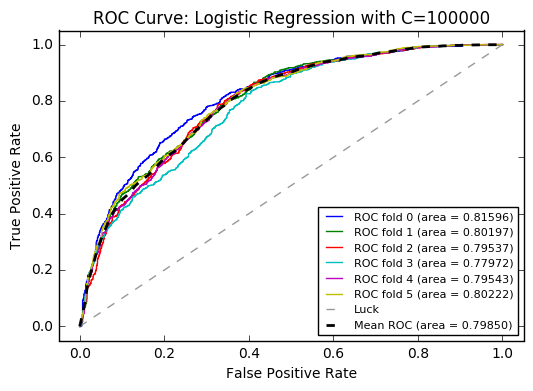

Logistic Regression CV start:  2016-12-06 08:09:25.106000
Logistic Regression CV end:  2016-12-06 08:10:35.213000
Logistic Regression with C=1000
Precision mean with standard deviation: 0.71063 (+/- 0.02317)
accuracy score normalized: 0.69575
accuracy score not normalized: 2783
F1 score binary: 0.697489435744
F1 score micro: 0.697489435744
F1 score weighted: 0.697489435744


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


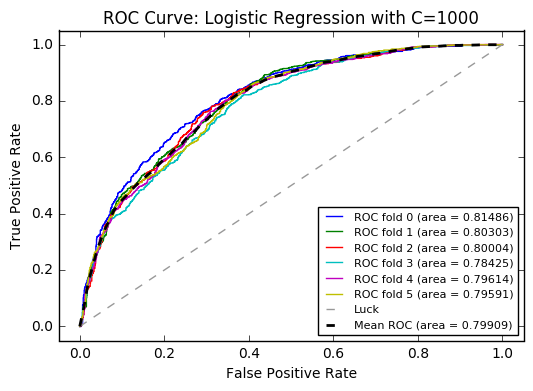

Logistic Regression CV start:  2016-12-06 08:11:53.009000
Logistic Regression CV end:  2016-12-06 08:12:52.685000
Logistic Regression with C=10
Precision mean with standard deviation: 0.70870 (+/- 0.01894)
Logistic Regression training end:  2016-12-06 08:13:05.966000
Logistic Regression with C=10
Accuracy: 0.71 (+/- 0.02)
accuracy score normalized: 0.71525
accuracy score not normalized: 2861
F1 score binary: 0.721855921856
F1 score micro: 0.721855921856
F1 score weighted: 0.721855921856


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


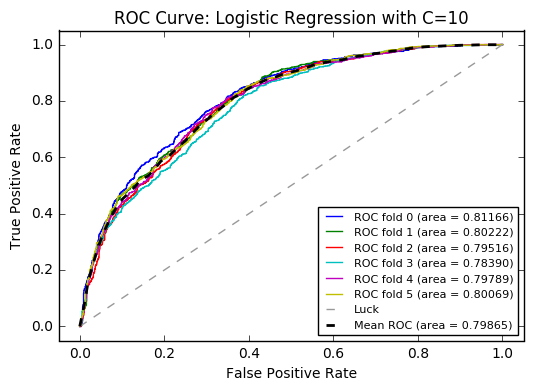

In [15]:
### Training prediction model

#LogisticRegression
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.externals import joblib
from datetime import datetime,date,time
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
%matplotlib inline 

# function to print ROC curve; passing parameter C, the trained model and cross validation object
def printROC(C, model, cvobj):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cvobj):
        probas_ = model.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.5f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cvobj)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.5f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str('ROC Curve: Logistic Regression with C=' + str(C)))
    plt.legend(loc="lower right", prop={'size':8})
    return plt

# Prepare cross validation training data
KFoldcv = StratifiedKFold(y_train, n_folds=6, random_state=42) #divide training set into 6 folds

##########################################
## train model using X_train with C=100000
C=100000
clfc5 = linear_model.LogisticRegression(C=C)
print "Logistic Regression CV start: ",datetime.now()
scores = cross_validation.cross_val_score(clfc5, X_train, y_train, cv=KFoldcv, scoring='precision')
print "Logistic Regression CV end: ",datetime.now()
print str("Logistic Regression with C=" + str(C))
print("Precision mean with standard deviation: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

################
clfc5.fit(X_train, y_train) 
# clf = joblib.load('.\Model\clf.pkl')

y_pred = list(clfc5.predict(X_test))
# print sum(y_pred)

#Evaluate model
print str("Logistic Regression with C=" + str(C))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "accuracy score normalized:", accuracy_score(y_test, y_pred)
print "accuracy score not normalized:", accuracy_score(y_test, y_pred, normalize=False)
print "F1 score binary:",f1_score(y_test, y_pred, average='binary')
print "F1 score micro:",f1_score(y_test, y_pred, average='micro')
print "F1 score weighted:",f1_score(y_test, y_pred, average='weighted') 
################

# Run ROC analysis and plot ROC curves
plt = printROC(C,clfc5, KFoldcv)
plt.show()


# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

# for i, (train, test) in enumerate(cv):
#     probas_ = clfc5.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
#     # Compute ROC curve and area the curve
#     fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
#     mean_tpr += interp(mean_fpr, fpr, tpr)
#     mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

# mean_tpr /= len(cv)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, 'k--',
#          label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve: Logistic Regression with C=100000')
# plt.legend(loc="lower right")
# plt.show()

##########################################
## train model using X_train with C=1000
C=1000
clfc3 = linear_model.LogisticRegression(C=C)
print "Logistic Regression CV start: ",datetime.now()
scores = cross_validation.cross_val_score(clfc3, X_train, y_train, cv=KFoldcv, scoring='precision')
print "Logistic Regression CV end: ",datetime.now()
print str("Logistic Regression with C=" + str(C))
print("Precision mean with standard deviation: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

################
clfc3.fit(X_train, y_train) 
# clf = joblib.load('.\Model\clf.pkl')


y_pred = list(clfc3.predict(X_test))
# print sum(y_pred)

#Evaluate model

print "accuracy score normalized:", accuracy_score(y_test, y_pred)
print "accuracy score not normalized:", accuracy_score(y_test, y_pred, normalize=False)
print "F1 score binary:",f1_score(y_test, y_pred, average='binary')
print "F1 score micro:",f1_score(y_test, y_pred, average='micro')
print "F1 score weighted:",f1_score(y_test, y_pred, average='weighted') 
################

plt = printROC(C,clfc3, KFoldcv)
plt.show()

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
# cv = StratifiedKFold(y_train, n_folds=6)

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

# for i, (train, test) in enumerate(cv):
#     probas_ = clfc3.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
#     # Compute ROC curve and area the curve
#     fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
#     mean_tpr += interp(mean_fpr, fpr, tpr)
#     mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

# mean_tpr /= len(cv)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, 'k--',
#          label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve: Logistic Regression with C=1000')
# plt.legend(loc="lower right")
# plt.show()

##########################################
## train model using X_train with C=10
C=10
clfc1 = linear_model.LogisticRegression(C=C)
print "Logistic Regression CV start: ",datetime.now()
scores = cross_validation.cross_val_score(clfc1, X_train, y_train, cv=KFoldcv, scoring='precision')
print "Logistic Regression CV end: ",datetime.now()
print str("Logistic Regression with C=" + str(C))
print("Precision mean with standard deviation: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

################
clfc1.fit(X_train, y_train) 
# clf = joblib.load('.\Model\clf.pkl')
print "Logistic Regression training end: ",datetime.now()

y_pred = list(clfc1.predict(X_test))
# print sum(y_pred)

#Evaluate model
print str("Logistic Regression with C=" + str(C))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "accuracy score normalized:", accuracy_score(y_test, y_pred)
print "accuracy score not normalized:", accuracy_score(y_test, y_pred, normalize=False)
print "F1 score binary:",f1_score(y_test, y_pred, average='binary')
print "F1 score micro:",f1_score(y_test, y_pred, average='micro')
print "F1 score weighted:",f1_score(y_test, y_pred, average='weighted') 
################

plt = printROC(C,clfc1, KFoldcv)
plt.show()


###############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
# cv = StratifiedKFold(y_train, n_folds=6)

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

# for i, (train, test) in enumerate(cv):
#     probas_ = clfc1.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
#     # Compute ROC curve and area the curve
#     fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
#     mean_tpr += interp(mean_fpr, fpr, tpr)
#     mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

# mean_tpr /= len(cv)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, 'k--',
#          label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve: Logistic Regression with C=10')
# plt.legend(loc="lower right")
# plt.show()





##  SVM

Beside logistic regression, I also try to use SVC estimator to see if I can improve the performance of the prediction model.   I used PCA function to reduce the feature dimension of my training data, and then I use FeatureUnion to combine the PCA reduced features with the best selected original features to feed the model training.  I used GridSearchCV function to find hyperparameters.  The parameters I tried including PCA component [1,2,3], best original feature [1,2], kernel [rbf, sigmoid] and C [0.1,1,10]. 


Results:
- The default rbf kernel seems to work the best and it takes relatively little time to train while the score performance is quite good. With the 16k training dataset, svc with rbf kernel takes about two minutes for the training to complete. For other kernel including linear and poly, the model just takes very very long time to train and I never get it finished. The Sigmoid kernel also takes short time to run, but its performance is quite poor comparing to rbf.

- Using the gridSearchCV function, the best hyperparameter I found is C=1, pca component=1, kernel=rbf and original feature=2 after the cross validation on the training dataset.   The overall precision score I got after applying the model to the testing dataset is 0.97.  

- Since SVC generates the best performing model comparing to linear regression, I will use the SVC model to find my next investment property.

In [ ]:
#################################################
#I didn't use this section in my capstone report


###############################################
# use gridSearchCV to find best hyper parameters for different scores method
tuned_parameters = [{'solver': ['liblinear'], 'penalty': ['l2', 'l1'],
                     'C': [1, 10, 1000, 100000]}]

scores = ['precision', 'recall', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(linear_model.LogisticRegression(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)  

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

## train model using X_train_scaled
# clf_scaled = linear_model.LogisticRegression(C=1e5)
# print "Logistic Regression scaled training start: ",datetime.now()
# clf_scaled.fit(X_train_scaled, y_train) 
# # clf_scaled = joblib.load('.\Model\clf_scaled.pkl')
# print "Logistic Regression scaled training end: ",datetime.now()
# y_pred_scaled = list(clf_scaled.predict(X_test_scaled))
# print sum(y_pred_scaled)

## store model to file
joblib.dump(clf, '.\Model\clf.pkl', compress=9)
joblib.dump(clf_scaled, '.\Model\clf_scaled.pkl', compress=9)

In [42]:
#################################################
#I didn't use this section in my capstone report


#LogisticRegression
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.externals import joblib
from datetime import datetime,date,time
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
%matplotlib inline 
# from sklearn.svm import SVC
# clf = GridSearchCV(linear_model.LogisticRegression(C=1), tuned_parameters, cv=5, scoring='%s_weighted' % score)

# linear_model.LogisticRegression(C=1).get_params()
# svm = SVC()
# print svm.get_params()


# solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}
# ValueError: Solver lbfgs supports only l2 penalties, got l1 penalty.
# ValueError: Solver sag supports only l2 penalties, got l1 penalty.
# ValueError: Solver newton-cg supports only l2 penalties, got l1 penalty.
###############################################
# use gridSearchCV to find best hyper parameters for different scores method
tuned_parameters = [{'solver': ['liblinear'], 'penalty': ['l2', 'l1'],
                     'C': [1, 10, 100, 1000,10000]}]

scores = ['precision', 'recall', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(linear_model.LogisticRegression(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)  

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'penalty': 'l1', 'C': 1, 'solver': 'liblinear'}
()
Grid scores on development set:
()
0.713 (+/-0.011) for {'penalty': 'l2', 'C': 1, 'solver': 'liblinear'}
0.723 (+/-0.020) for {'penalty': 'l1', 'C': 1, 'solver': 'liblinear'}
0.707 (+/-0.011) for {'penalty': 'l2', 'C': 10, 'solver': 'liblinear'}
0.722 (+/-0.020) for {'penalty': 'l1', 'C': 10, 'solver': 'liblinear'}
0.713 (+/-0.018) for {'penalty': 'l2', 'C': 100, 'solver': 'liblinear'}
0.722 (+/-0.020) for {'penalty': 'l1', 'C': 100, 'solver': 'liblinear'}
0.713 (+/-0.024) for {'penalty': 'l2', 'C': 1000, 'solver': 'liblinear'}
0.722 (+/-0.021) for {'penalty': 'l1', 'C': 1000, 'solver': 'liblinear'}
0.716 (+/-0.011) for {'penalty': 'l2', 'C': 10000, 'solver': 'liblinear'}
0.722 (+/-0.020) for {'penalty': 'l1', 'C': 10000, 'solver': 'liblinear'}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores ar

ValueError: 'f2_weighted' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']

SGD Classifier scaled training start:  2016-09-18 16:29:58.874000
SGD Classifier scaled training end:  2016-09-18 16:29:58.957000
2149.0
SGD Classifier scaled with alpha=0.001
Accuracy: 0.58 (+/- 0.07)
accuracy score normalized: 0.726
accuracy score not normalized: 2904
F1 score binary: 0.737044145873
F1 score micro: 0.737044145873
F1 score weighted: 0.737044145873
accuracy score normalized(scaled): 0.726
accuracy score not normalized(scaled): 2904
F1 score binary(scaled): 0.737044145873
F1 score micro(scaled): 0.737044145873
F1 score weighted(scaled): 0.737044145873


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-pack

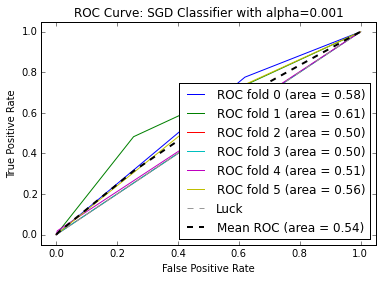

SGD Classifier scaled training start:  2016-09-18 16:30:01.964000
SGD Classifier scaled training end:  2016-09-18 16:30:02.016000
1909.0
SGD Classifier scaled with alpha=0.001
Accuracy: 0.54 (+/- 0.05)
accuracy score normalized: 0.6795
accuracy score not normalized: 2718
F1 score binary: 0.673625254582
F1 score micro: 0.673625254582
F1 score weighted: 0.673625254582
accuracy score normalized(scaled): 0.6795
accuracy score not normalized(scaled): 2718
F1 score binary(scaled): 0.673625254582
F1 score micro(scaled): 0.673625254582
F1 score weighted(scaled): 0.673625254582


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-pack

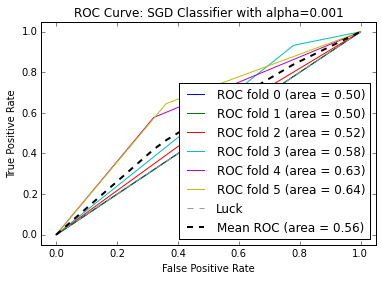

In [64]:
#################################################
#I didn't use this section in my capstone report


### Training prediction model

#SGD Classifier
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.externals import joblib
from datetime import datetime,date,time
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
%matplotlib inline 

##########################################
## train model using X_train - alpha=0.001
clf_sgd_scaled001 = linear_model.SGDClassifier(alpha=0.001,loss='log')
print "SGD Classifier scaled training start: ",datetime.now()
clf_sgd_scaled001.fit(X_train_scaled, y_train) 
# clf_scaled = joblib.load('.\Model\clf_sgd_scaled.pkl')
print "SGD Classifier scaled training end: ",datetime.now()
y_pred_sgd_scaled = list(clf_sgd_scaled001.predict(X_test_scaled))
print sum(y_pred_sgd_scaled)

#Evaluate model
scores_sgd_scaled = cross_validation.cross_val_score(clf_sgd_scaled001, X_train, y_train, cv=5)
# print "alpha=0.001", scores_sgd
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores_sgd_scaled.mean(), scores_sgd_scaled.std() * 2))
print "SGD Classifier scaled with alpha=0.001"
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_sgd_scaled.mean(), scores_sgd_scaled.std() * 2))
print "accuracy score normalized:", accuracy_score(y_test, y_pred_sgd_scaled)
print "accuracy score not normalized:", accuracy_score(y_test, y_pred_sgd_scaled, normalize=False)
print "F1 score binary:",f1_score(y_test, y_pred_sgd_scaled, average='binary')
print "F1 score micro:",f1_score(y_test, y_pred_sgd_scaled, average='micro')
print "F1 score weighted:",f1_score(y_test, y_pred_sgd_scaled, average='weighted') 

print "accuracy score normalized(scaled):", accuracy_score(y_test, y_pred_sgd_scaled)
print "accuracy score not normalized(scaled):", accuracy_score(y_test, y_pred_sgd_scaled, normalize=False)
###### QUESTION: Why the F1 scores for all scaled results are all 0.1???????
print "F1 score binary(scaled):",f1_score(y_test, y_pred_sgd_scaled, average='binary')
print "F1 score micro(scaled):",f1_score(y_test, y_pred_sgd_scaled, average='micro')
print "F1 score weighted(scaled):",f1_score(y_test, y_pred_sgd_scaled, average='weighted') 

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y_train, n_folds=6)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = clf_sgd_scaled001.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SGD Classifier with alpha=0.001')
plt.legend(loc="lower right")
plt.show()


##########################################
## train model using X_train - alpha=0.1
clf_sgd_scaled1 = linear_model.SGDClassifier(alpha=0.1,loss='log')
print "SGD Classifier scaled training start: ",datetime.now()
clf_sgd_scaled1.fit(X_train_scaled, y_train) 
# clf_scaled = joblib.load('.\Model\clf_sgd_scaled.pkl')
print "SGD Classifier scaled training end: ",datetime.now()
y_pred_sgd_scaled = list(clf_sgd_scaled1.predict(X_test_scaled))
print sum(y_pred_sgd_scaled)

#Evaluate model
scores_sgd_scaled = cross_validation.cross_val_score(clf_sgd_scaled1, X_train, y_train, cv=5)
# print "alpha=0.001", scores_sgd
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores_sgd_scaled.mean(), scores_sgd_scaled.std() * 2))
print "SGD Classifier scaled with alpha=0.001"
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_sgd_scaled.mean(), scores_sgd_scaled.std() * 2))
print "accuracy score normalized:", accuracy_score(y_test, y_pred_sgd_scaled)
print "accuracy score not normalized:", accuracy_score(y_test, y_pred_sgd_scaled, normalize=False)
print "F1 score binary:",f1_score(y_test, y_pred_sgd_scaled, average='binary')
print "F1 score micro:",f1_score(y_test, y_pred_sgd_scaled, average='micro')
print "F1 score weighted:",f1_score(y_test, y_pred_sgd_scaled, average='weighted') 

print "accuracy score normalized(scaled):", accuracy_score(y_test, y_pred_sgd_scaled)
print "accuracy score not normalized(scaled):", accuracy_score(y_test, y_pred_sgd_scaled, normalize=False)
###### QUESTION: Why the F1 scores for all scaled results are all 0.1???????
print "F1 score binary(scaled):",f1_score(y_test, y_pred_sgd_scaled, average='binary')
print "F1 score micro(scaled):",f1_score(y_test, y_pred_sgd_scaled, average='micro')
print "F1 score weighted(scaled):",f1_score(y_test, y_pred_sgd_scaled, average='weighted') 

# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
# cv = StratifiedKFold(y_train, n_folds=6)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = clf_sgd_scaled1.fit(X_train.iloc[train], y_train.iloc[train]).predict_proba(X_train.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SGD Classifier with alpha=0.001')
plt.legend(loc="lower right")
plt.show()


#Evaluate model


## store model to file
# joblib.dump(clf, '.\Model\clf_sgd.pkl', compress=9)
# joblib.dump(clf_scaled, '.\Model\clf_sgd_scaled.pkl', compress=9)

##  SVM

Beside logistic regression, I also try to use SVC estimator to see if I can improve the performance of the prediction model.   I used PCA function to reduce the feature dimension of my training data, and then I use FeatureUnion to combine the PCA reduced features with the best selected original features to feed the model training.  I used GridSearchCV function to find hyperparameters.  The parameters I tried including PCA component [1,2,3], best original feature [1,2], kernel [rbf, sigmoid] and C [0.1,1,10]. 


Results:
- The default rbf kernel seems to work the best and it takes relatively little time to train while the score performance is quite good. With the 16k training dataset, svc with rbf kernel takes about two minutes for the training to complete. For other kernel including linear and poly, the model just takes very very long time to train and I never get it finished. The Sigmoid kernel also takes short time to run, but its performance is quite poor comparing to rbf.

- Using the gridSearchCV function, the best hyperparameter I found is C=1, pca component=1, kernel=rbf and original feature=2 after the cross validation on the training dataset.   The overall precision score I got after applying the model to the testing dataset is 0.97.  

- Since SVC generates the best performing model comparing to linear regression, I will use the SVC model to find my next investment property.


In [16]:
### Training prediction model

# Apply PCA to reduce feature and train with SVM
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datetime import datetime,date,time
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import classification_report
%matplotlib inline

# Prepare cross validation training data
KFoldcv = StratifiedKFold(y_train, n_folds=6, random_state=42) #divide training set into 6 folds

# create PCA
pca = PCA(n_components=2)

# Maybe some original features where good
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
# print "SVC training start: ",datetime.now()
X_features = combined_features.fit_transform(X_train, y_train)#.transform(X_train)

# svm = SVC(kernel="rbf")
svm = SVC()

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])
# param_grid = dict(features__pca__n_components=[1, 2],
#                   features__univ_select__k=[1],
#                   svm__C=[10])
param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__kernel=['rbf','sigmoid'],
                  svm__C=[0.1, 1, 10])
# param_grid = dict(features__pca__n_components=[1, 2, 3],
#                   features__univ_select__k=[1],
#                   svm__kernel=['rbf'],
#                   svm__C=[0.1, 1, 10])
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10, scoring="precision", cv=KFoldcv)
# grid_search.fit(X_features, y_train)
# print(grid_search.best_estimator_)
# X_features_test = combined_features.transform(X_test) #.transform(X_test)
# y_predsvm = list(grid_search.predict(X_features_test))
# print sum(y_predsvm)

# print "SVC training end: ",datetime.now()
scores = ['precision', 'f1_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=KFoldcv, scoring='%s' % score)
    clf.fit(X_features, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))
    print()
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    X_features_test = combined_features.transform(X_test) #.transform(X_test)
    y_true, y_predsvm = y_test, clf.predict( X_features_test)
    print(classification_report(y_true, y_predsvm))
    print()

###### disable following code temparrily before I finish the gridsearchSV change
# ## plot confusion matrix
# def plot_confusion_matrix(cm, title='SVC Evaluation Zipcode Prediction Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(np.array(["cold","hot"])))
#     plt.xticks(tick_marks, np.array(["cold","hot"]), rotation=45)
#     plt.yticks(tick_marks, np.array(["cold","hot"]))
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_predsvm)
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure()
# plot_confusion_matrix(cm)

# # Normalize the confusion matrix by row (i.e by the number of samples
# # in each class)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='SVC Evaluation Zipcode Prediction normalized Confusion matrix')

# plt.show()

#Evaluate model
# print "accuracy store normalized:", accuracy_score(y_test, y_predsvm)
# print "accuracy store normalized:", accuracy_score(y_test, y_predsvm, normalize=False)
# print "F1 store binary:",f1_score(y_test, y_predsvm, average='binary')
# print "F1 store micro:",f1_score(y_test, y_predsvm, average='micro')
# print "F1 store weighted:",f1_score(y_test, y_predsvm, average='weighted')

# Tuning hyper-parameters for precision
()


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
()
{'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 2}
()
Grid scores on development set:
()
0.500 (+/-0.250) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
1.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
1.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.500 (+/-0.250) for {'features__pca__n_components': 1, 'svm__

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
()
{'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 2}
()
Grid scores on development set:
()
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.944 (+/-0.003) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.944 (+/-0.003) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__

In [ ]:
### The following is my own playground testing work which is not meant to be reviewed. 


In [23]:
#################################################
#I didn't use this section in my capstone report because this version doesn't use CV in the gridsearch

### Training prediction model

# Apply PCA to reduce feature and train with SVM
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datetime import datetime,date,time
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedKFold
%matplotlib inline

# Prepare cross validation training data
KFoldcv = StratifiedKFold(y_train, n_folds=6, random_state=42) #divide training set into 6 folds

# create PCA

# pca = PCA()
# pca.fit(X_train)
# pca_dimen = pca.explained_variance_


# >>> # As we can see, only the 2 first components are useful
# >>> pca.n_components = 2
# >>> X_reduced = pca.fit_transform(X)
# >>> X_reduced.shape
# (100, 2)

pca = PCA(n_components=2)

# Maybe some original features where good
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
print "SVC training start: ",datetime.now()
X_features = combined_features.fit_transform(X_train, y_train)#.transform(X_train)

# svm = SVC(kernel="rbf")
svm = SVC()

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])
# param_grid = dict(features__pca__n_components=[1, 2],
#                   features__univ_select__k=[1],
#                   svm__C=[10])
# param_grid = dict(features__pca__n_components=[1, 2, 3],
#                   features__univ_select__k=[1, 2],
#                   svm__kernel=['rbf','sigmoid'],
#                   svm__C=[0.1, 1, 10])
param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1],
                  svm__kernel=['rbf'],
                  svm__C=[0.1, 1, 10])
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10, scoring="precision", cv=KFoldcv)
grid_search.fit(X_features, y_train)
print(grid_search.best_estimator_)
X_features_test = combined_features.transform(X_test) #.transform(X_test)
y_predsvm = list(grid_search.predict(X_features_test))
print sum(y_predsvm)
print "SVC training end: ",datetime.now()

###### disable following code temparrily before I finish the gridsearchSV change
# ## plot confusion matrix
# def plot_confusion_matrix(cm, title='SVC Evaluation Zipcode Prediction Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(np.array(["cold","hot"])))
#     plt.xticks(tick_marks, np.array(["cold","hot"]), rotation=45)
#     plt.yticks(tick_marks, np.array(["cold","hot"]))
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_predsvm)
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure()
# plot_confusion_matrix(cm)

# # Normalize the confusion matrix by row (i.e by the number of samples
# # in each class)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='SVC Evaluation Zipcode Prediction normalized Confusion matrix')

# plt.show()

#Evaluate model
print "accuracy store normalized:", accuracy_score(y_test, y_predsvm)
print "accuracy store normalized:", accuracy_score(y_test, y_predsvm, normalize=False)
print "F1 store binary:",f1_score(y_test, y_predsvm, average='binary')
print "F1 store micro:",f1_score(y_test, y_predsvm, average='micro')
print "F1 store weighted:",f1_score(y_test, y_predsvm, average='weighted') 


SVC training start:  2016-11-25 19:46:48.370000
Fitting 6 folds for each of 9 candidates, totalling 54 fits
[CV] features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   27.0s


[CV]  features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  27.0s
[CV] features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  26.4s
[CV] features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  25.3s
[CV] features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  18.1s
[CV] features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 


[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:  1.6min


[CV]  features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  11.8s
[CV] features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  23.6s
[CV] features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  46.4s
[CV] features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 


[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:  3.0min


[CV]  features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  45.8s
[CV] features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=0.999132 - 1.9min
[CV] features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=0.997449 - 1.2min
[CV] features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=0.997449 - 1.3min
[CV] features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=0.999164 - 1.2min
[CV] features__pca__n_components=1, svm__C=10, svm__kern

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:  9.4min


[CV]  features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=0.999146 - 1.4min
[CV] features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.5min
[CV] features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=0.998265 - 2.0min
[CV] features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=0.997449 - 1.7min
[CV] features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=0.997449 - 1.9min
[CV] features__pca__n_components=1, svm__C=10, 

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed: 17.9min


[CV]  features__pca__n_components=1, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=0.999164 - 1.5min
[CV] features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  26.1s
[CV] features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  26.9s
[CV] features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  22.6s
[CV] features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  28.3s
[CV] features__pca__n_components=2, svm

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed: 21.9min


[CV]  features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  51.5s
[CV] features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  45.0s
[CV] features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.3min
[CV] features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.2min
[CV] features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  55.4s
[CV] features__pca__n_components=2, svm__C=1, svm__kerne

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed: 29.1min


[CV]  features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.9min
[CV] features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 2.2min
[CV] features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.9min
[CV] features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 2.0min
[CV] features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  58.2s
[CV] features__pca__n_components=3, svm__C=0.1,

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 39.9min


[CV]  features__pca__n_components=3, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  19.0s
[CV] features__pca__n_components=3, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=0.1, svm__kernel=rbf, features__univ_select__k=1, score=0.000000 -  29.2s
[CV] features__pca__n_components=3, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.6min
[CV] features__pca__n_components=3, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.5min
[CV] features__pca__n_components=3, svm__C=1, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.8min
[CV] features__pca__n_components=3, svm__C=1, svm_

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 50.2min


[CV]  features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.8min
[CV] features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.8min
[CV] features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 -  56.2s
[CV] features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.1min
[CV] features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, svm__kernel=rbf, features__univ_select__k=1, score=1.000000 - 1.5min


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 57.3min finished


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('univ_select', SelectKBest(k=1, score_func=<function f_classif at 0x000000001DA93F28>))],
       transformer_weights=None)), ('svm', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
1880.0
SVC training end:  2016-11-25 20:45:12.456000
accuracy store normalized: 0.96525
accuracy store normalized: 3861
F1 store binary: 0.964349833291
F1 store micro: 0.964349833291
F1 store weighted: 0.964349833291


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [21]:
### Training prediction model

# Apply PCA to reduce feature and train with SVM
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datetime import datetime,date,time
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import classification_report
%matplotlib inline

# Prepare cross validation training data
KFoldcv = StratifiedKFold(y_train, n_folds=6, random_state=42) #divide training set into 6 folds

# create PCA
pca = PCA(n_components=2)

# Maybe some original features where good
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:
combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
# print "SVC training start: ",datetime.now()
X_features = combined_features.fit_transform(X_train, y_train)#.transform(X_train)

# svm = SVC(kernel="rbf")
svm = SVC()

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])
# param_grid = dict(features__pca__n_components=[1, 2],
#                   features__univ_select__k=[1],
#                   svm__C=[10])
param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__kernel=['rbf','sigmoid'],
                  svm__C=[0.1, 1, 10])
# param_grid = dict(features__pca__n_components=[1, 2, 3],
#                   features__univ_select__k=[1],
#                   svm__kernel=['rbf'],
#                   svm__C=[0.1, 1, 10])
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10, scoring="precision", cv=KFoldcv)
# grid_search.fit(X_features, y_train)
# print(grid_search.best_estimator_)
# X_features_test = combined_features.transform(X_test) #.transform(X_test)
# y_predsvm = list(grid_search.predict(X_features_test))
# print sum(y_predsvm)

# print "SVC training end: ",datetime.now()
scores = ['precision', 'f1_weighted']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=KFoldcv, scoring='%s' % score)
    clf.fit(X_features, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))
    print()
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    X_features_test = combined_features.transform(X_test) #.transform(X_test)
    y_true, y_predsvm = y_test, clf.predict( X_features_test)
    print(classification_report(y_true, y_predsvm))
    print()

###### disable following code temparrily before I finish the gridsearchSV change
# ## plot confusion matrix
# def plot_confusion_matrix(cm, title='SVC Evaluation Zipcode Prediction Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(np.array(["cold","hot"])))
#     plt.xticks(tick_marks, np.array(["cold","hot"]), rotation=45)
#     plt.yticks(tick_marks, np.array(["cold","hot"]))
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_predsvm)
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure()
# plot_confusion_matrix(cm)

# # Normalize the confusion matrix by row (i.e by the number of samples
# # in each class)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='SVC Evaluation Zipcode Prediction normalized Confusion matrix')

# plt.show()

#Evaluate model
# print "accuracy store normalized:", accuracy_score(y_test, y_predsvm)
# print "accuracy store normalized:", accuracy_score(y_test, y_predsvm, normalize=False)
# print "F1 store binary:",f1_score(y_test, y_predsvm, average='binary')
# print "F1 store micro:",f1_score(y_test, y_predsvm, average='micro')
# print "F1 store weighted:",f1_score(y_test, y_predsvm, average='weighted')

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 2}
()
Grid scores on development set:
()
0.167 (+/-0.186) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
1.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
1.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.000 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.000 (+/-0.000) fo

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
()
{'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 2}
()
Grid scores on development set:
()
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 0.1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.943 (+/-0.002) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 1, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.943 (+/-0.002) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'rbf', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__C': 10, 'svm__kernel': 'sigmoid', 'features__univ_select__k': 1}
0.335 (+/-0.000) for {'features__pca__n_components': 1, 'svm__

Confusion matrix, without normalization
[[1339  642]
 [ 549 1470]]
Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.27  0.73]]


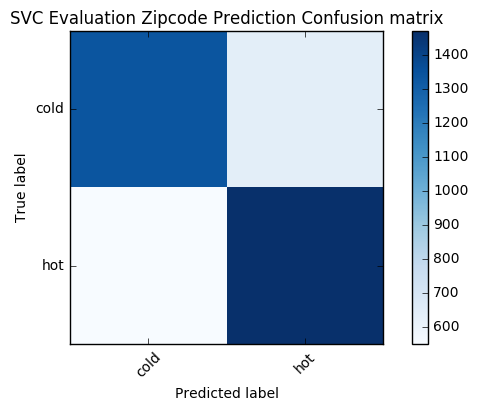

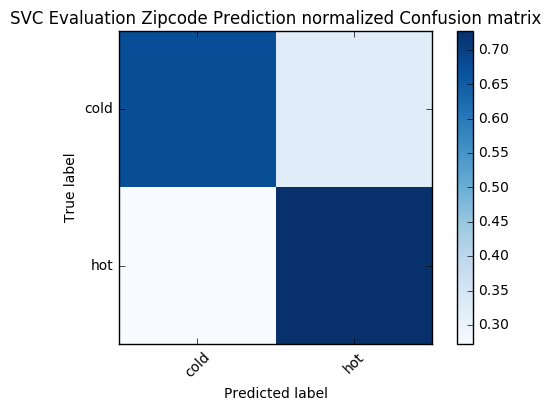

In [20]:
##### disable following code temparrily before I finish the gridsearchSV change
## plot confusion matrix
def plot_confusion_matrix(cm, title='SVC Evaluation Zipcode Prediction Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.array(["cold","hot"])))
    plt.xticks(tick_marks, np.array(["cold","hot"]), rotation=45)
    plt.yticks(tick_marks, np.array(["cold","hot"]))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_predsvm)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='SVC Evaluation Zipcode Prediction normalized Confusion matrix')

plt.show()

Confusion matrix, without normalization
[[1981    0]
 [ 176 1843]]
Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.09  0.91]]


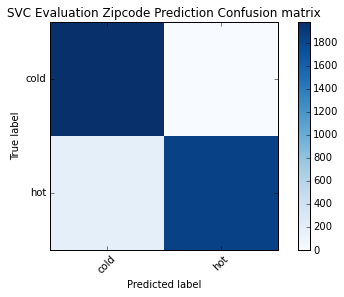

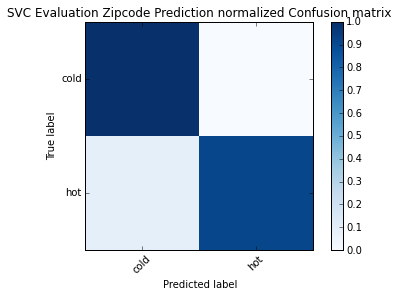

accuracy store normalized: 0.956
accuracy store normalized: 3824
F1 store binary: 0.954427757639
F1 store micro: 0.954427757639
F1 store weighted: 0.954427757639


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [7]:
import numpy as np
## plot confusion matrix
def plot_confusion_matrix(cm, title='SVC Evaluation Zipcode Prediction Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.array(["cold","hot"])))
    plt.xticks(tick_marks, np.array(["cold","hot"]), rotation=45)
    plt.yticks(tick_marks, np.array(["cold","hot"]))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(y_test, y_predsvm)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='SVC Evaluation Zipcode Prediction normalized Confusion matrix')

plt.show()

#Evaluate model
print "accuracy store normalized:", accuracy_score(y_test, y_predsvm)
print "accuracy store normalized:", accuracy_score(y_test, y_predsvm, normalize=False)
print "F1 store binary:",f1_score(y_test, y_predsvm, average='binary')
print "F1 store micro:",f1_score(y_test, y_predsvm, average='micro')
print "F1 store weighted:",f1_score(y_test, y_predsvm, average='weighted') 

Confusion matrix, without normalization
[[1981    0]
 [ 165 1854]]


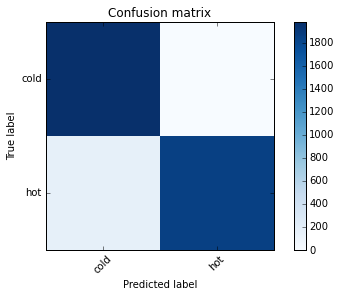

In [54]:
## plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.array(["cold","hot"])))
    plt.xticks(tick_marks, np.array(["cold","hot"]), rotation=45)
    plt.yticks(tick_marks, np.array(["cold","hot"]))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(y_test, y_predsvm)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

### The following is my own playground testing work which is not meant to be reviewed. 

In [ ]:
import pandas

import numpy as np
import itertools

# tuples = [t for t in itertools.product(range(1000), range(4))]
# index = pandas.MultiIndex.from_tuples(tuples, names=['lvl0', 'lvl1'])
# data = np.random.randn(len(index),4)
# df = pandas.DataFrame(data, columns=list('ABCD'), index=index)
grouped = df.groupby(level='lvl1')
# grouped.boxplot()
# df
# tuples
grouped = df.unstack(level='lvl1').groupby(level=0, axis=1)
print df.unstack(level='lvl1')
grouped.boxplot(subplots=True)

In [ ]:
dfPredictZipCodeFinal3 = dfPredictZipCodeFinal.copy()
dfPredictZipCodeFinal3.set_index(['Month', 'ZipCode'],inplace=True)
dfPredictZipCodeFinal3.boxplot(by='PredictZipCode')
dfPredictZipCodeFinal3.head()

In [ ]:
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal.copy()
dfPredictZipCodeFinal2.set_index(['Month', 'ZipCode','PredictZipCode'],inplace=True)
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.ix[:,0:4]
dfPredictZipCodeFinal2 = pd.DataFrame(dfPredictZipCodeFinal2.unstack())
# dfPredictZipCodeFinal3 = pd.DataFrame(dfPredictZipCodeFinal2['All Homes'])
# dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.T.reorder_levels([1,0]).T
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.stack(level=1)
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.unstack(level=2)
dfPredictZipCodeFinal2.columns.names = ['PredictZipCode','HomeCol']
dfPredictZipCodeFinal2
grouped = dfPredictZipCodeFinal2.groupby(axis=1, level=0)
grouped.boxplot(subplots=True)

# fig, ax1 = plt.subplots(figsize=(30, 6))
# fig.canvas.set_window_title('A Boxplot Example')
# plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

# bp = plt.boxplot(dfPredictZipCodeFinal2, notch=0, sym='+', vert=1, whis=1.5)
# plt.setp(bp['boxes'], color='black')
# plt.setp(bp['whiskers'], color='black')
# plt.setp(bp['fliers'], color='red', marker='+')

In [ ]:
# dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinal.groupby('PredictZipCode')
dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinal.set_index(['Month','ZipCode','PredictZipCode'])
dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinalBoxplot.unstack(level=2)
dfPredictZipCodeFinalBoxplot.head()


In [ ]:
# X_test
X_test['PredictZipCode'] = y_pred
X_test['ZipCode'][X_test['PredictZipCode'] == 1.0]


# ypd = pd.DataFrame(y_pred)
# ypd == Trues

# X_testsvm = X_test.copy()
# X_testsvm['PredictZipCode'] = y_pred
# X_testsvm['ZipCode'][X_testsvm['PredictZipCode'] == 1.0]


In [ ]:
from datetime import datetime,date,time
print "start: ",datetime.now()
# print "start: ", datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
### This cell is trying to combine the individual california zipcode data .p pickle file into a singe file
### so the main analytic code can load all zipcodes and their distance difference into a single data frame.

import os
import glob
import pandas as pd
from os import path
path = '.\\DataPfiles\\'

calzipcodeAllLong = pd.DataFrame()    
for filename in glob.glob(os.path.join(path, 'calzip*.p')):
    calzipcodeAllLong = pd.concat([calzipcodeAllLong, pd.read_pickle(filename)], axis=1)

dfname = './DataPfiles/' + 'calzipcodeAllLong' + ".p"
pickle.dump( calzipcodeAllLong, open( dfname, "wb" ) )
print 'Done: ' + dfname

In [ ]:
##Abnormally Detection method TWO
##Find out zipcode in df..InZipCode which has z score > 2 and in df..AcrossZipCode among the 10 closest zipcodes which has z score > 2



### This cell is trying to calculate the distance between two zipcodes (within California) in miles
import pandas as pd
import pickle
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from math import radians, cos, sin, asin, sqrt
def calculateDistance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


geolocator = Nominatim()

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

startzipcodeIndex = int(100)    #last batch processed by script at test.ipynb
endzipcodeIndex = int(200)

for z in calzipcode.iloc[startzipcodeIndex:endzipcodeIndex,0]:
# for z in calzipcode.iloc[2:3,0]:
# for z in calzipcode['Postal Code']:    
    for i,r in calzipcode.iterrows():
        ziplon1 = calzipcode[calzipcode['Postal Code'] == int(z)]['Longitude']
        ziplat1 = calzipcode[calzipcode['Postal Code'] == int(z)]['Latitude']
        ziplon2 = r['Longitude']
        ziplat2 = r['Latitude']
        calzipcode.loc[i,z] = calculateDistance(ziplon1,ziplat1,ziplon2,ziplat2)

dfname = './DataPfiles/' + 'calzip' + str(int(calzipcode.iloc[startzipcodeIndex]['Postal Code'])) + "_to_" + str(int(calzipcode.iloc[endzipcodeIndex-1]['Postal Code'])) + ".p"
pickle.dump( calzipcode, open( dfname, "wb" ) )
print 'Done: ' + dfname
 
    
# geolocator = Nominatim()
# location = geolocator.geocode("94582")
# print(location.address)
# print((location.latitude, location.longitude))
# print(location.raw)

# # >> newport_ri = (41.49008, -71.312796)
# # >>> cleveland_oh = (41.499498, -81.695391)
# print(vincenty((geolocator.geocode("94582").latitude,geolocator.geocode("94582").longitude), (geolocator.geocode("94122").latitude,geolocator.geocode("94122").longitude)).miles)

In [ ]:
### This cell as well as the cell after this one are just my playground to play with different functions.  This is not part of the project. 


from pylab import plot, ylim, xlim, show, xlabel, ylabel
from numpy import linspace, loadtxt
import numpy as np

r=3.0

x = p.head()
y = pz

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# plot(x,y)
# xlim(0,1000)

x_av = movingaverage(x, r)
# plot(x_av, y)

# xlabel("Months since Jan 1749.")
# ylabel("No. of Sun spots")
# show()
print x_av

p = df11.iloc[:,0]  #ALl Homes price
pz = df11.iloc[:,-1] 
print pz


t1 = df.iloc[:,1] 
t2 = df3.iloc[:,0]
print "mean is % 4.3F and sd is % 4.3F " % (t1.mean(),t1.std
                                            
                                            # add a new column for moving average of All Homes price


p = df11.iloc[:,0] #ALl Homes price
pz = df11.iloc[:,-1] 


window_size = 3.0 #set the number of sample to gathering centered in the middle
movingave = lambda x: np.convolve(x, np.ones(int(window_size))/float(window_size), 'same')
transformed = df11.groupby('ZipCode')
transformed['All Homes'].transform(movingave)
# df11.info()

# df11 = df11[df11['All Homes'].isnull()]
grouped = df11[['All Homes','ZipCode']].groupby('ZipCode')
b = pd.DataFrame()
newdf = pd.DataFrame()
for name,group in grouped:
    g = group.copy()
#     print group.shape
#     print "size: % 3.2F" % movingaverage(group['All Homes'],3).size
#     if sum(g.isnull()) < 0:
#         g['Moving Ave'] = movingaverage(group['All Homes'],3)

#     print g.shape
#     print g.head()

    #     if(newdf.isnull):
#         newdf = g
#     newdf = newdf.append(g)
#     b = group['All Homes']
#     a = movingaverage(group['All Homes'],3)
    
#     group["MovingAve"] = np.convolve(group['All Homes'], np.ones(int(window_size))/float(window_size), 'same')
#     newdf = newdf.append(group)
# print b
# newdf
# newdf.info()
    
    


# df11['Moving Ave'] = movingaverage(df11.iloc[:,0], 3)  #para#1 is All Homes price; para#2 is numer of sample to gather centered in the middle

# df11.head()
x                                             

In [ ]:
np.average(dfAllHomes['93063'][(-1-y):-1])

In [ ]:
import pandas as pd
#dfAllHomesDiffFromMovAve

In [ ]:
print dfAllHomesStdDevAcrossZipCode.shape
# dfAllHomesStdDevAcrossZipCode
# np.sum(dfAllHomesStdDevAcrossZipCode > 2)

In [ ]:
#dfAllHomesDiffFromMovAve.mean(axis =1 )

In [ ]:
dfAllHomesDiffFromMovAve.std(axis = 1)

In [ ]:
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

geolocator = Nominatim()
location = geolocator.geocode("94582")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

# >> newport_ri = (41.49008, -71.312796)
# >>> cleveland_oh = (41.499498, -81.695391)
print(vincenty((geolocator.geocode("94582").latitude,geolocator.geocode("94582").longitude), (geolocator.geocode("94122").latitude,geolocator.geocode("94122").longitude)).miles)

In [ ]:
import pandas as pd
import pickle

df = pickle.load( open( ".\DataPfiles\calzip90001_to_90010.p", "rb" ) ) 

# print "abcde"
# zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
# calzipcode = zipcode[zipcode.State == 'California']

In [ ]:
import os
from os import path
files = [f for f in os.listdir(".\DataPfiles\\")]# if path.isfile(f)]
files
# print os.listdir(".\DataPfiles\\")

In [ ]:
PtoR = dfPriceToRent.mean()
print dfPriceToRent.mean(),dfPriceToRent.std()
print PtoR.mean(),PtoR.std()

highPtoRzip = pd.DataFrame(dfPriceToRent.mean() > 18)
highPtoRzip[highPtoRzip[0] == True]
# targetZipCodes[targetZipCodes[0] == True]

In [ ]:
# calzipcode = zipcode[zipcode.State == 'California']

# irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
# print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
# irsdata2007 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

# irsdata2007 = irsdata2007[irsdata2007['Range'] == ""]
# irsdata2007 = irsdata2007.drop('Range', axis=1, inplace=True)
# irsdata2007['AverageAGI'] = irsdata2007.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
# irsdata2007['NumberOfReturns'] = irsdata2007['NumberOfReturns'].astype(int)
# irsdata2007['AverageAGI'] = irsdata2007['AverageAGI'] * 1000 / irsdata2007.NumberOfReturns
# print irsdata2007['AverageAGI'].mean()


# irsdata = pd.read_csv('./DataPfiles/ZIPCode2006CA.csv',header=4, na_values=['**','--'])
# irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
#           'TaxableInterestRtn','TaxableInterestAmt', \
#           'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleFTotalRtn',\
#           'ScheduleARtn'
#           ]
# irsdata.columns= irsCol
# irsdata['ZipCode']

# print type(irsdata2007['Range'])
# import numpy as np
# L = [4,np.nan ,6]
# dftest = Series(L)
# dftest.apply(np.isnan)
# np.isNan(dftest)
# np.isnan()
# sum(irsdata2007.Range == "NaN")
# irsdata2007.Range 

dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
print "done"
dfPredictZipCodeFinal
# dfPredictZipCode.unstack(level=1)
# irsdatafull.unstack(level=1)

In [ ]:
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCodeFinal.unstack(level=1),irsdata2001full.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)

# b = dfPredictZipCodeFinal.index.get_level_values(0) == '1998-09-30'  #for testing the result
# # b1 = dfPredictZipCodeFinal.index.get_level_values(0) == '2001-09-30'  #for testing the result
# dfPredictZipCodeFinal[b]  #for testing the result

# irsdatafull = irsdata1998full
# irsdatafull = irsdatafull.append(irsdata2001full)
# irsdatafull = irsdatafull.append(irsdata2002full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
# dfPredictZipCodeFinal

b = dfPredictZipCodeFinal.index.get_level_values(0) == '1998-09-30'  #for testing the result
b1 = dfPredictZipCodeFinal.index.get_level_values(0) == '2001-09-30'  #for testing the result
b2 = dfPredictZipCodeFinal.index.get_level_values(0) == '2002-09-30'  #for testing the result
b4 = dfPredictZipCodeFinal.index.get_level_values(0) == '2004-09-30'  #for testing the result
b5 = dfPredictZipCodeFinal.index.get_level_values(0) == '2005-09-30'  #for testing the result
b6 = dfPredictZipCodeFinal.index.get_level_values(0) == '2006-09-30'  #for testing the result
b7 = dfPredictZipCodeFinal.index.get_level_values(0) == '2007-09-30'  #for testing the result
b8 = dfPredictZipCodeFinal.index.get_level_values(0) == '2008-09-30'  #for testing the result
b9 = dfPredictZipCodeFinal.index.get_level_values(0) == '2009-09-30'  #for testing the result
b10 = dfPredictZipCodeFinal.index.get_level_values(0) == '2010-09-30'  #for testing the result
b11 = dfPredictZipCodeFinal.index.get_level_values(0) == '2011-09-30'  #for testing the result
dfPredictZipCodeFinal[b11].head(5)  #for testing the result

In [ ]:
dfPredictZipCodeFinal.info()
# dfPredictZipCodeFinal['TotalTaxAmt']

In [ ]:
dffinaltest = dfPredictZipCodeFinal.copy()
# dffinaltest.mean
dffinaltest1 = dffinaltest.fillna(method='backfill')
dffinaltest2 = dffinaltest1.dropna(axis=0,how='any')
dffinaltest2.describe().ix[:,10:36]
# dffinaltest2['SalariesWagesAmt']

In [ ]:
dffinaltest = dfPredictZipCodeFinal.copy()
# dffinaltest.mean
dffinaltest1 = dffinaltest.dropna()
dffinaltest1.info()
dffinaltest2 = dffinaltest1.mean(axis=0)
dffinaltest2
# dffinaltest1 = dffinaltest1.ix[:,0:2]
# dffinaltest1.mean(axis=0)

In [ ]:
dffinaltest = dfPredictZipCodeFinal.copy()
a = "nan"
# nalist = dffinaltest['DepedentExemptionsAmt'].str.contains("NaN", na=True)
# dffinaltest.ix[nalist,'DepedentExemptionsAmt'] == np.nan

# dffinaltest['DepedentExemptionsAmt'] = dffinaltest['DepedentExemptionsAmt'].convert_objects(convert_numeric=True)
dffinaltest = dffinaltest.convert_objects(convert_numeric=True)
# dffinaltest['DependentExemptionsAmt'] = dffinaltest['DependentExemptionsAmt'].astype(float)
dffinaltest2 = dffinaltest.fillna(dffinaltest.mean(numeric_only=True))

dffinaltest2['DepedentExemptionsAmt']

# dffinaltest['DepedentExemptionsAmt']
# pd.isnull(dffinaltest['DepedentExemptionsAmt'])

# dffinaltest['DepedentExemptionsAmt'].fillna("abc")
# dffinaltest['DepedentExemptionsAmt']
# a = np.nan
# np.isnan(a)
# type(a)